
# Exploratory Data Analysis

## Objectives

This notebook performs **exploratory data analysis (EDA)** on the enriched datasets to understand book performance, catalog diversity, and user behavior.

The goal is to extract insights that guide:

* Feature engineering
* Predictive modeling
* Dashboard visualisation
* Business interpretation (ratings, satisfaction, catalog suitability)

---

## Inputs

* `en_supply_catalog.csv` — enriched BBE (supply) catalog
* `en_internal_catalog.csv` — enriched Goodbooks catalog
* `ratings_clean.csv` — cleaned user–book interactions
* `model_dataset_warm_start.csv` — unified metadata + external signals
* `model_dataset_cold_start.csv` — unified metadata (no external signals)

---

## Tasks in This Notebook

1. **Load Data**
    Read in enriched catalogs and interaction data.

2. **Internal Catalog and Supply Catalog Comparison**
   Genre mix, popularity spread, publication-year coverage.

3. **Performance Analysis**
   Ratings, popularity, publication trends, outliers.

4. **Correlation & Feature Signal Study**
   Identify which variables show predictive potential.

5. **User Behavior Exploration**
   Rating patterns, user activity, interaction sparsity.

6. **Feature Engineering Recommendations**
   Identify variables needing transformation, encoding, or imputation.

7. **Generate Dashboard-Ready Visualisations**
   Plots to be reused in the Streamlit “Data Explorer” page.

---

## Outputs

* Summary tables and plots for book performance, diversity, and behavior
* Correlation & feature signal diagnostics
* Dashboard-ready visualisations (saved to `outputs/eda_plots/`)
* Notes on recommended feature transformations for Notebook 05

>**Note:**
>This notebook focuses on **analysis only**.
>Feature engineering and modeling are completed in the following notebooks.

# Set up

## Navigate to the Parent Directory

Before combining and saving datasets, it’s often helpful to move to a parent directory so that file operations (like loading or saving data) are easier and more organized. 

Before using the Python’s built-in os module to move one level up from the current working directory, it is advisable to inspect the current directory.

In [ ]:
import os

# Get the current working directory
current_dir = os.getcwd()
print(f'Current directory: {current_dir}')

To change to parent directory (root folder), run the code below. If you are already in the root folder, you can skip this step.

In [ ]:
# Change the working directory to its parent
os.chdir(os.path.dirname(current_dir))
print('Changed directory to parent.')

# Get the new current working directory (the parent directory)
current_dir = os.getcwd()
print(f'New current directory: {current_dir}')

## Load Datasets

In this step, we load the previously cleaned datasets for analysis.

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

internal_catalog = pd.read_csv(
    'outputs/datasets/cleaned/en_internal_catalog.csv',
    dtype={"isbn_clean": "string", "goodreads_id_clean": "string"}
    )
ratings_clean = pd.read_csv('outputs/datasets/cleaned/ratings_clean_v1.csv')
supply_catalog = pd.read_csv(
    "outputs/datasets/cleaned/en_supply_catalog.csv",
    dtype={"isbn_clean": "string", "goodreads_id_clean": "string"}
)

## Load Imports

In [ ]:
# Ensure output directory exists
from pathlib import Path

plots_dir = Path('outputs/eda_plots')
plots_dir.mkdir(parents=True, exist_ok=True)
print(f"Plots directory ready: {plots_dir}")

In [ ]:
from src.eda.plot_comparison import (
    plot_genre_comparison,
    plot_author_comparison,
    plot_major_publisher_comparison,
    plot_rating_distributions,
    plot_publication_year_comparison
)
from src.eda.plot_distribution import (
    plot_top_books,
    plot_top_genres,
    plot_top_authors,
    plot_awards_rating,
    plot_boolean_pie_chart,
    plot_top_publishers,
)
from src.eda.utils import create_volume_bins
import matplotlib.pyplot as plt

# Prepare Data for Analysis

In this step, we prepare the datasets for exploratory data analysis (EDA).

To be able to do this, we will use the enriched datasets loaded in the previous step. Majority of our data is in textual form, so we need to convert them into numerical format for analysis. 
 
 We created a feature engineering module in `src/modeling/feature_engineering.py` to help with this task. Some values will need preparation steps before feature engineering, those are `genres_clean` and `publication_date_clean`.

In [ ]:
from src.cleaning.utils.helpers import safe_literal_eval

# apply to both catalogs before feature engineering
internal_catalog['genres_clean'] = internal_catalog['genres_clean'].apply(safe_literal_eval)
supply_catalog['genres_clean'] = supply_catalog['genres_clean'].apply(safe_literal_eval)

print("Genres converted to lists successfully.")
print("\nSample after conversion:")
print(internal_catalog['genres_clean'].head(5))

from src.cleaning.utils.dates import extract_year

# transform both catalogs' publication_date_clean to extract year
internal_catalog['publication_year_clean'] = internal_catalog['publication_date_clean'].apply(extract_year)
supply_catalog['publication_year_clean'] = supply_catalog['publication_date_clean'].apply(extract_year)

print("Year extraction complete.")
print(f"\nInternal catalog - Valid years: {internal_catalog['publication_year_clean'].notna().sum()}")
print(f"Supply catalog - Valid years: {supply_catalog['publication_year_clean'].notna().sum()}")
print(f"\nYear range (internal): {internal_catalog['publication_year_clean'].min()} - {internal_catalog['publication_year_clean'].max()}")
print(f"Year range (supply): {supply_catalog['publication_year_clean'].min()} - {supply_catalog['publication_year_clean'].max()}")

In [ ]:
from src.modeling.feature_engineering import fe_engineering

# apply feature engineering to internal catalog
internal_catalog_fe = fe_engineering(
    df=internal_catalog,
    encode_text_embeddings=False,
    top_n_authors=50,
    top_n_genres=30,
    bool_cols=['has_award', 'is_major_publisher'], 
    text_col='description_clean',
    genres_col='genres_clean',
    author_col='author_clean',
    publisher_col='publisher_clean',
    series_col='series_clean'
)

print(f"Internal catalog shape: {internal_catalog_fe.shape}")
print(f"New features added: {set(internal_catalog_fe.columns) - set(internal_catalog.columns)}")
display(internal_catalog_fe.head())

In [ ]:
# apply feature engineering to supply catalog
supply_catalog_fe = fe_engineering(
    df=supply_catalog,
    encode_text_embeddings=False,
    top_n_authors=50,
    top_n_genres=30,
    bool_cols=['has_award', 'is_major_publisher'],
    text_col='description_clean',
    genres_col='genres_clean',
    author_col='author_clean',
    publisher_col='publisher_clean',
    series_col='series_clean'
)

print(f"Supply catalog shape: {supply_catalog_fe.shape}")
print(f"New features added: {set(supply_catalog_fe.columns) - set(supply_catalog.columns)}")
display(supply_catalog_fe.head())

# Internal Catalog and Supply Catalog Comparison

In this section, we analyze and compare the internal catalog and supply catalog based on key features like genres, ratings, and publication years.

## Genre Distribution Comparison

In [ ]:
# explode genre lists to count individual genres
print("=== EXPLODING GENRE LISTS FOR INDIVIDUAL GENRE COUNTING ===")

# explode lists so each genre gets its own row
internal_genres_exploded = (
    internal_catalog
    .explode('genres_clean')
    .loc[:, ['book_id', 'genres_clean', 'rating_clean']]
    .dropna(subset=['genres_clean'])
)
# save exploded mapping
# ensure output directory exists
out_dir = Path('outputs/eda_plots')
out_dir.mkdir(parents=True, exist_ok=True)

internal_genres_exploded.to_csv(
    out_dir / 'internal_book_genre_mapping.csv', 
    index=False
)
supply_genres_exploded = supply_catalog.explode('genres_clean')

print(f"Internal catalog - Original rows: {len(internal_catalog)}, Exploded rows: {len(internal_genres_exploded)}")
print(f"Supply catalog - Original rows: {len(supply_catalog)}, Exploded rows: {len(supply_genres_exploded)}")

# remove NaN genres
internal_genres_exploded = internal_genres_exploded[internal_genres_exploded['genres_clean'].notna()]
supply_genres_exploded = supply_genres_exploded[supply_genres_exploded['genres_clean'].notna()]

print(f"\nAfter removing NaN:")
print(f"Internal catalog: {len(internal_genres_exploded)} rows")
print(f"Supply catalog: {len(supply_genres_exploded)} rows")

In [ ]:
# Compute mean ratings and counts per INDIVIDUAL genre
print("=== COMPUTING INDIVIDUAL GENRE STATISTICS ===")

# Internal catalog
internal_genre_stats = (
    internal_genres_exploded
    .groupby('genres_clean')['rating_clean']
    .agg(['mean', 'count'])
    .sort_values('count', ascending=False)
)
internal_genre_stats.columns = ['avg_rating', 'book_count']

print("\nInternal Catalog - Top 20 Individual Genres by Count:")
display(internal_genre_stats.head(20))

# Supply catalog
supply_genre_stats = (
    supply_genres_exploded
    .groupby('genres_clean')['rating_clean']
    .agg(['mean', 'count'])
    .sort_values('count', ascending=False)
)
supply_genre_stats.columns = ['avg_rating', 'book_count']

print("\nSupply Catalog - Top 20 Individual Genres by Count:")
display(supply_genre_stats.head(20))

# ensure output directory exists
out_dir = Path('outputs/eda_plots')
out_dir.mkdir(parents=True, exist_ok=True)

# save
internal_genre_stats.to_csv(out_dir / 'internal_genre_stats.csv')
supply_genre_stats.to_csv(out_dir / 'supply_genre_stats.csv')
print("\nGenre statistics saved")

In [ ]:
# Ensure output directory exists
from pathlib import Path

plots_dir = Path('outputs/eda_plots')
plots_dir.mkdir(parents=True, exist_ok=True)

# Plot Genre comparison between catalogs
plot_genre_comparison(internal_catalog, supply_catalog, top_n=30)
plt.savefig(
    'outputs/eda_plots/genre_comparison.png',
    dpi=150,
    bbox_inches='tight'
)
print("Saved to outputs/eda_plots/genre_comparison.png")

While both catalogs concentrate heavily in Fiction, Fantasy, Romance, and Young Adult, the internal catalog’s stronger skew toward Fiction/Fantasy indicates a more mainstream, commercial-fantasy oriented profile, possibly reflecting historical member preferences or curation choices. The supply catalog’s relatively higher share of Non-Fiction and Romance suggests a broader and more flexible offering. 

Niche genres, such Literaty Fiction, Classics, Contemporary Romance and History, are underrepresented in both catalogs, but the internal catalog has a marginally higher presence in Literary Fiction and Classics while supply has a higher presence of History and Contemporary Romance.

This reinforces the idea that expanding selectively into underrepresented but available genres may increase catalog diversity and better support personalization, especially for new or niche reader segments.

## Author Comparison

In [ ]:
plot_author_comparison(internal_catalog, supply_catalog, top_n=30)
plt.savefig(
    'outputs/eda_plots/author_comparison.png',
    dpi=150,
    bbox_inches='tight'
)
print("Saved to outputs/eda_plots/author_comparison.png")

The comparison reveals a strong concentration of specific high-output or high-popularity authors in the internal catalog (e.g. Stephen King, Nora Roberts, Terry Prachett), while the supply catalog shows a more evenly distributed but overall lower presence across these top authors.

In contrast, the supply catalog presents smaller but more consistent contributions across many of the same authors. Only a few authors, such as Piers Anthony, Erin Hunter, Orson Scott Card, and Richelle Mead, have a relatively higher representation in the supply catalog, indicating that while the supply offers works from diversity of top authors, internal curation emphasizes a more selective and heavily skewed subset.

A noteworthy observation is the presence of "Not a Book" in the top authors for the internal catalog, which points to metadata noise or misclassified entries that may need cleaning.

## Major Publisher Distribution Comparison

In [ ]:
fig = plot_boolean_pie_chart(
    df=internal_catalog,
    boolean_col='is_major_publisher',
    catalog_name='Internal Catalog',
    true_label='Major Publisher',
    false_label='Indie Publisher',
    colors=['#ffcc99', '#99ccff']
)
fig.savefig('outputs/eda_plots/internal_major_publisher_pie.png', dpi=150, bbox_inches='tight')

fig = plot_boolean_pie_chart(
    df=supply_catalog,
    boolean_col='is_major_publisher',
    catalog_name='Supply Catalog',
    true_label='Major Publisher',
    false_label='Indie Publisher',
    colors=['#ffcc99', '#99ccff']
)
fig.savefig('outputs/eda_plots/supply_major_publisher_pie.png', dpi=150, bbox_inches='tight')


The internal catalog shows a slightly higher share of **major publishers (51.2%)**, which aligns with the earlier observation that it features a stronger concentration of established, high-profile authors. This suggests that the internal catalog leans more toward traditionally published, commercially successful titles—likely reflecting curation decisions based on reliability, brand recognition, and proven reader appeal.

In contrast, the supply catalog displays a **larger proportion of indie and small-press publishers (57.9%)**, indicating greater diversity and broader market availability from less mainstream sources. This suggests that the supply side contains a richer mix of niche voices, emerging authors, and self-published works, which may not yet be represented in the internal curated selection.

Despite these differences, the overall near-balanced split in both catalogs, close to 50/50, indicates **healthy publisher diversity**. The internal catalog maintains a strong foundation of major-publisher titles while still incorporating a substantial share of indie content, and the supply catalog offers an even wider spectrum. Together, this provides a strong ecosystem for both mainstream and alternative publishing, with clear opportunities to expand internal diversity by leveraging the indie-heavy supply catalog.

## Awards Winners Distribution Comparison

In [ ]:
fig = plot_boolean_pie_chart(
    df=internal_catalog,
    boolean_col='has_award',
    catalog_name='Internal Catalog',
    true_label='Has Award',
    false_label='No Award'
)
fig.savefig('outputs/eda_plots/internal_award_pie.png', dpi=150, bbox_inches='tight')

fig = plot_boolean_pie_chart(
    df=supply_catalog,
    boolean_col='has_award',
    catalog_name='Supply Catalog',
    true_label='Has Award',
    false_label='No Award'
)
fig.savefig('outputs/eda_plots/supply_award_pie.png', dpi=150, bbox_inches='tight')


When examining the award distribution, the pattern aligns with insights from previous plots: the internal catalog, which leans more heavily on major publishers and established authors, shows a significantly higher proportion of award-winning titles. This reflects industry dynamics, where large publishing houses are more likely to promote authors for major awards or acquire rising talents after they receive recognition. In contrast, the supply catalog, characterized by a broader presence of indie and small-press publishers, naturally contains fewer award-tagged books, consistent with the lower visibility and limited promotional reach of independent titles. Together, the charts reinforce a coherent narrative: the internal catalog gravitates toward mainstream, high-profile works, while the supply catalog offers wider diversity and representation of independent, non-award titles.

## In Series Distribution Comparison

In [ ]:
# Convert in_series to boolean for internal catalog
internal_catalog_fe['in_series'] = internal_catalog_fe['in_series'].astype(bool)

fig = plot_boolean_pie_chart(
    df=internal_catalog_fe,
    boolean_col='in_series',
    catalog_name='Internal Catalog',
    true_label='Part of Series',
    false_label='Standalone',
    title='Series vs Standalone Books Distribution'
)
fig.savefig('outputs/eda_plots/internal_series_pie.png', dpi=150, bbox_inches='tight')
plt.show()

# Do the same for supply catalog
supply_catalog_fe['in_series'] = supply_catalog_fe['in_series'].astype(bool)

fig = plot_boolean_pie_chart(
    df=supply_catalog_fe,
    boolean_col='in_series',
    catalog_name='Supply Catalog',
    true_label='Part of Series',
    false_label='Standalone',
    title='Series vs Standalone Books Distribution'
)
fig.savefig('outputs/eda_plots/supply_series_pie.png', dpi=150, bbox_inches='tight')
plt.show()

This is a notable finding: nearly half of both catalogs consist of books that are part of a series. Given the strong presence of Fantasy, Romance, and Young Adult, genres where multi-book arcs and extended universes are common, this distribution is unsurprising. It also highlights an important structural characteristic of the catalog: series-driven reading patterns are likely a major factor in user engagement and should be considered in recommendation and curation strategies.

## Rating Distribution Comparison

In [ ]:
from src.eda.plot_comparison import plot_rating_distributions

# Generate the plot
fig = plot_rating_distributions(internal_catalog, supply_catalog)

# Display it
plt.show()

# Or save it
fig.savefig('rating_distribution_comparison.png', dpi=300, bbox_inches='tight')

Both catalogs show a fairly normal and tightly clustered rating distribution centered around 4.0–4.2, indicating a generally positive bias typical of user-generated book ratings. The supply catalog, however, exhibits a noticeable micro-peak at the maximum rating (5.0), which may signal rating inflation, niche subgenres with highly enthusiastic audiences, or potential data-quality issues.

To investigate the rating-5 anomaly in the supply catalog, next steps include:

* **Inspecting the top-rated titles** (list books with rating = 5).
* **Checking rating volume** (are these books highly rated or do they have very few votes?).
* **Comparing genres or publishers** (is the spike driven by specific categories or indie/self-pub titles?).
* **Reviewing external rating sources** to validate whether these perfect scores are consistent.

This will help determine whether the peak reflects genuine reader enthusiasm or structural noise in the data.

### Investigate Top-Rated Titles

In [27]:
print("\nTOP-RATED TITLES (Rating = 5.0)\n")

perfect_ratings = supply_catalog[supply_catalog['rating_clean'] == 5.0].copy()
print(f"Total books with perfect 5.0 rating: {len(perfect_ratings)}")
print(f"Percentage of catalog: {len(perfect_ratings) / len(supply_catalog) * 100:.2f}%\n")

# Display sample of perfect-rated books
display_cols = ['title_clean', 'author_clean', 'rating_clean', 'numRatings_clean', 'genres_clean']
print("Sample of books with rating = 5.0:")
display(perfect_ratings[display_cols].head(20))

# Rating volume analysis
perfect_ratings['rating_volume_bin'] = create_volume_bins(
    perfect_ratings['numRatings_clean'],
    bin_edges=[0, 10, 50, 100, 500, float('inf')],
    labels=['Very Low (≤10)', 'Low (11-50)', 'Medium (51-100)', 'High (101-500)', 'Very High (>500)']
)

volume_distribution = perfect_ratings['rating_volume_bin'].value_counts().sort_index()
print("\nRating volume distribution for 5.0-rated books:")
print(volume_distribution)

# Genre distribution for perfect-rated books
perfect_genres_exploded = perfect_ratings.explode('genres_clean')
perfect_genre_counts = perfect_genres_exploded['genres_clean'].value_counts().head(10)
print("\nTop 15 genres in 5.0-rated books:")
print(perfect_genre_counts)

# Publisher analysis
perfect_pub_dist = perfect_ratings['is_major_publisher'].value_counts()
print("\nPublisher type distribution for 5.0-rated books:")
print(f"  Major publishers: {perfect_pub_dist.get(True, 0)} ({perfect_pub_dist.get(True, 0) / len(perfect_ratings) * 100:.1f}%)")
print(f"  Indie publishers: {perfect_pub_dist.get(False, 0)} ({perfect_pub_dist.get(False, 0) / len(perfect_ratings) * 100:.1f}%)")

# External rating validation
if 'likedPercent_clean' in perfect_ratings.columns:
    print("\nComparing internal rating (5.0) with external likedPercent:")
    liked_stats = perfect_ratings['likedPercent_clean'].describe()
    print(liked_stats)

    high_consistency = perfect_ratings[perfect_ratings['likedPercent_clean'] >= 90]
    print(f"\nHigh consistency (≥90% liked): {len(high_consistency)} books ({len(high_consistency)/len(perfect_ratings)*100:.1f}%)")


# SUMMARY
print("\n" + "=" * 80)
print("SUMMARY OF FINDINGS")
print("=" * 80)
print(f"Total 5.0-rated books: {len(perfect_ratings)}")
print(f"Books with <10 ratings: {(perfect_ratings['numRatings_clean'] < 10).sum()}")
print(f"Indie publisher ratio: {perfect_pub_dist.get(False, 0) / len(perfect_ratings) * 100:.1f}%")
if 'likedPercent_clean' in perfect_ratings.columns:
    print(f"Median external liked %: {perfect_ratings['likedPercent_clean'].median():.1f}%")
print("=" * 80)


TOP-RATED TITLES (Rating = 5.0)

Total books with perfect 5.0 rating: 515
Percentage of catalog: 1.21%

Sample of books with rating = 5.0:


,title_clean,author_clean,rating_clean,numRatings_clean,genres_clean
4164,obscured darkness,rebekah mcclew,5.0,9,[]
4867,elliptical door,lucio agustine rosenkreutz craciunescu,5.0,12,[]
5378,females of valor,widad akreyi,5.0,2,[]
5401,the daughter of kurdland a life dedicated to h...,widad akreyi,5.0,5,[]
6393,patience's love,ronda paige,5.0,10,[]
8036,abstraction in theory - laws of physical trans...,subhajit ganguly,5.0,6,[]
9535,of just the two of us,le-an lai lacaba,5.0,15,[]
9891,liam midsummer's magic bonus book,emmie lou kates,5.0,17,[]
10254,freddy the fire hydrant finds his purpose,lisa g rorman,5.0,1,[]
10329,the best scandal ever,ina disguise,5.0,5,[]



Rating volume distribution for 5.0-rated books:
Very Low (≤10)      500
Low (11-50)          15
Medium (51-100)       0
High (101-500)        0
Very High (>500)      0
Name: rating_volume_bin, dtype: int64

Top 15 genres in 5.0-rated books:
poetry                  3
fantasy                 2
zombies                 2
romance                 2
historical fiction      1
middle grade            1
art                     1
science                 1
new adult romance       1
contemporary romance    1
Name: genres_clean, dtype: int64

Publisher type distribution for 5.0-rated books:
  Major publishers: 66 (12.8%)
  Indie publishers: 449 (87.2%)

Comparing internal rating (5.0) with external likedPercent:
count    362.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
Name: likedPercent_clean, dtype: float64

High consistency (≥90% liked): 362 books (70.3%)

SUMMARY OF FINDINGS
Total 5.0-rated books: 515
Books with <10 ratings: 496
Indi

The analysis reveals that almost all 5.0-rated books in the supply catalog are based on extremely low rating counts (**median = 2**, with **96% of titles having ≤10 ratings**). These books overwhelmingly originate from **indie or self-publishing houses (87%)**, with only a small fraction coming from major publishers. Genre presence is sparse and scattered, indicating no coherent thematic signal. External validation (`likedPercent`) shows uniformly perfect scores, which, combined with low rating volume, suggests rating inflation or artificially skewed feedback, rather than genuine high performance. Overall, the perfect rating cluster reflects data sparsity rather than book quality, reinforcing the need for weighted or Bayesian rating adjustments before using rating features for modeling or recommendation logic. 

## Publication Year Distribution Comparison

In [ ]:
plot_publication_year_comparison(internal_catalog, supply_catalog)
plt.savefig('outputs/eda_plots/publication_year_distribution_comparison.png', dpi=150, bbox_inches='tight')

The supply catalog shows a strong concentration of books published after 2010, reflecting the recency of the Best Books Ever dataset from which it is derived. In contrast, the internal catalog spans a wider historical range, including older classics and mid-20th-century titles. This indicates that the supply catalog is skewed toward newer releases, while the internal collection maintains broader temporal diversity.

# Performance Analysis

In this section, we will identify high performance books, show what categories, authors and publisher perform best.

## Major Publisher vs Indie Publisher 

In [ ]:
plot_major_publisher_comparison(internal_catalog, supply_catalog)
plt.savefig(
    'outputs/eda_plots/publisher_comparison.png',
    dpi=150,
    bbox_inches='tight'
)
print("Saved to outputs/eda_plots/publisher_comparison.png")

Both catalogs show the same pattern: books from non-major publishers receive slightly higher average ratings than those from major publishers. This is likely driven by niche or genre-specific imprints, where smaller publishers often serve highly engaged, loyal readerships that tend to rate books more positively. Major publishers, by contrast, cover a wider and more diverse audience, which typically results in more moderate rating averages. 

## Top Publishers by Average Rating

In [ ]:
fig = plot_top_publishers(internal_catalog, min_books=5, catalog_name='Internal Catalog')
fig.savefig('outputs/eda_plots/internal_top_publishers.png', dpi=150, bbox_inches='tight')
plt.show()
fig = plot_top_publishers(supply_catalog, min_books=5, catalog_name='Internal Catalog')
fig.savefig('outputs/eda_plots/supply_top_publishers.png', dpi=150, bbox_inches='tight')
plt.show()

The publishers with the highest average ratings are predominantly indie or small presses, but this ranking is heavily influenced by their low publication volume rather than true consistency in quality. With fewer titles, a handful of highly rated books can disproportionately elevate a publisher’s average. Larger publishers, with broader and more diverse catalogs, naturally show more moderate rating averages. As a result, high scores among indie publishers should be interpreted cautiously, as they reflect sample-size effects rather than reliable indicators of superior quality.

=== PUBLISHER SAMPLE SIZE EFFECT ANALYSIS ===

SUMMARY STATISTICS BY VOLUME CATEGORY:



avg_rating                      ci_width book_count
                      mean    std    min    max     mean       mean
volume_category                                                    
Very Low (1-5)       4.024  0.242  3.040  4.760    0.389      1.567
Low (6-10)           4.002  0.158  3.708  4.368    0.288      7.278
Medium (11-20)       4.036  0.138  3.742  4.470    0.218     15.146
High (21-50)         4.033  0.153  3.778  4.277    0.160     30.697
Very High (>50)      4.012  0.037  3.973  4.075    0.053    781.000


HIGH-RATED LOW-VOLUME PUBLISHERS (≤5 books, rating ≥4.5): 14
HIGH-RATED HIGH-VOLUME PUBLISHERS (>20 books, rating ≥4.5): 0

Saved: outputs/eda_plots/publisher_sample_size_effect.png


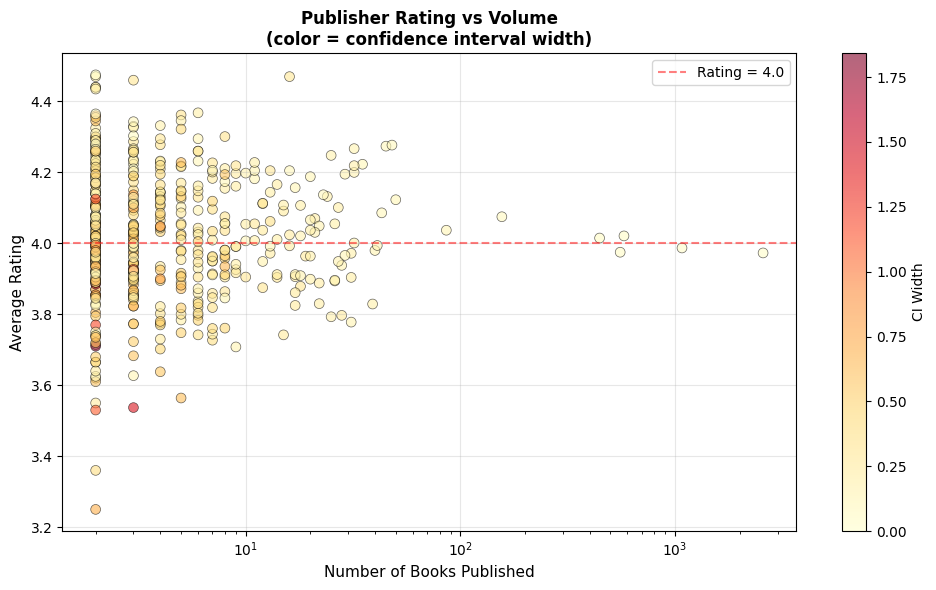


KEY FINDINGS
1. 14 low-volume publishers (≤5 books) have rating ≥4.5
2. Only 0 high-volume publishers (>20 books) have rating ≥4.5
3. Low-volume avg CI width: 0.389
4. High-volume avg CI width: 0.141


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

print("=== PUBLISHER SAMPLE SIZE EFFECT ANALYSIS ===\n")

# Calculate publisher statistics
publisher_stats = internal_catalog.groupby('publisher_clean').agg({
    'rating_clean': ['mean', 'std', 'count', 'sem']
}).round(3)
publisher_stats.columns = ['avg_rating', 'std_rating', 'book_count', 'std_error']
publisher_stats = publisher_stats.reset_index()

# Calculate confidence intervals (95%)
publisher_stats['ci_lower'] = publisher_stats['avg_rating'] - (1.96 * publisher_stats['std_error'])
publisher_stats['ci_upper'] = publisher_stats['avg_rating'] + (1.96 * publisher_stats['std_error'])
publisher_stats['ci_width'] = publisher_stats['ci_upper'] - publisher_stats['ci_lower']


# Categorize by volume
publisher_stats['volume_category'] = create_volume_bins(
    publisher_stats['book_count'],
    bin_edges=[0, 5, 10, 20, 50, float('inf')],
    labels=['Very Low (1-5)', 'Low (6-10)', 'Medium (11-20)', 'High (21-50)', 'Very High (>50)']
)

# Summary statistics
print("SUMMARY STATISTICS BY VOLUME CATEGORY:\n")
summary = publisher_stats.groupby('volume_category').agg({
    'avg_rating': ['mean', 'std', 'min', 'max'],
    'ci_width': 'mean',
    'book_count': 'mean'
}).round(3)
display(summary)

# Compare high-rated publishers
low_vol_high_rating = publisher_stats[
    (publisher_stats['book_count'] <= 5) & 
    (publisher_stats['avg_rating'] >= 4.5)
]
high_vol_high_rating = publisher_stats[
    (publisher_stats['book_count'] > 20) & 
    (publisher_stats['avg_rating'] >= 4.5)
]

print(f"\nHIGH-RATED LOW-VOLUME PUBLISHERS (≤5 books, rating ≥4.5): {len(low_vol_high_rating)}")
print(f"HIGH-RATED HIGH-VOLUME PUBLISHERS (>20 books, rating ≥4.5): {len(high_vol_high_rating)}")

# Single key visualization - scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(
    publisher_stats['book_count'],
    publisher_stats['avg_rating'],
    c=publisher_stats['ci_width'],
    s=50,
    alpha=0.6,
    cmap='YlOrRd',
    edgecolors='black',
    linewidth=0.5
)
ax.set_xlabel('Number of Books Published', fontsize=11)
ax.set_ylabel('Average Rating', fontsize=11)
ax.set_title('Publisher Rating vs Volume\n(color = confidence interval width)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.axhline(y=4.0, color='red', linestyle='--', alpha=0.5, label='Rating = 4.0')
ax.legend()
plt.colorbar(scatter, ax=ax, label='CI Width')

plt.tight_layout()
plt.savefig('outputs/eda_plots/publisher_sample_size_effect.png', dpi=150, bbox_inches='tight')
print("\nSaved: outputs/eda_plots/publisher_sample_size_effect.png")
plt.show()

# Key findings
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print(f"1. {len(low_vol_high_rating)} low-volume publishers (≤5 books) have rating ≥4.5")
print(f"2. Only {len(high_vol_high_rating)} high-volume publishers (>20 books) have rating ≥4.5")
print(f"3. Low-volume avg CI width: {publisher_stats[publisher_stats['book_count']<=5]['ci_width'].mean():.3f}")
print(f"4. High-volume avg CI width: {publisher_stats[publisher_stats['book_count']>20]['ci_width'].mean():.3f}")
print("="*80)

## Award Winners vs Non-Award Winners

Saved to outputs/eda_plots/award_comparison.png


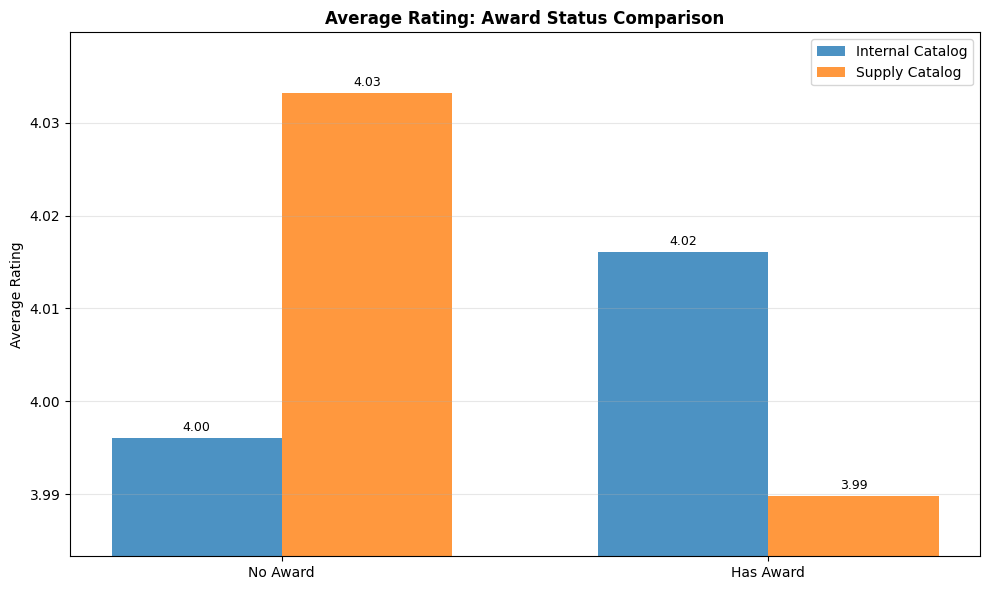

In [29]:
from src.eda.plot_comparison import plot_award_comparison

# Generate the plot
fig = plot_award_comparison(internal_catalog, supply_catalog)

# Save it
fig.savefig(
    'outputs/eda_plots/award_comparison.png',
    dpi=150,
    bbox_inches='tight'
)
print("Saved to outputs/eda_plots/award_comparison.png")

The differences in average rating between award-winning and non-award books are extremely small in both catalogs. This is expected: awards reflect industry recognition, not necessarily higher average user ratings, which tend to cluster tightly between 3.8 and 4.2 across most books. In the internal catalog, award-winning titles are rated only slightly higher, while in the supply catalog they are slightly lower. This is likely due to dataset composition rather than quality differences. Overall, the plot suggests that award status does not strongly influence average ratings, reinforcing that awards function more as a prestige signal than a predictor of user-rated performance.

## Top Genres by Average Rating

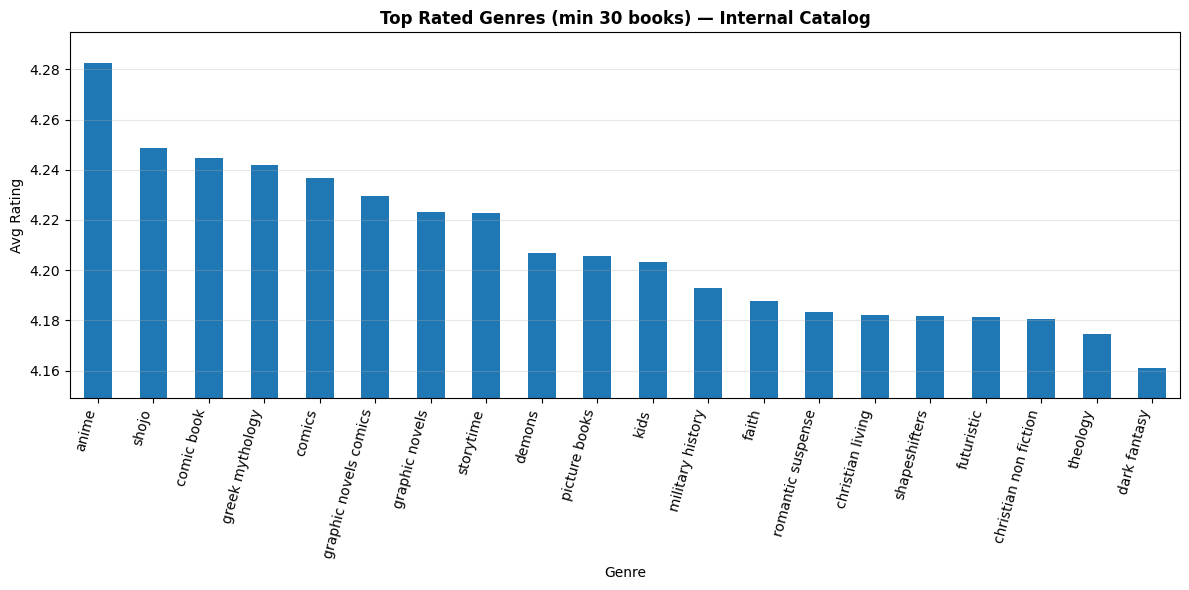

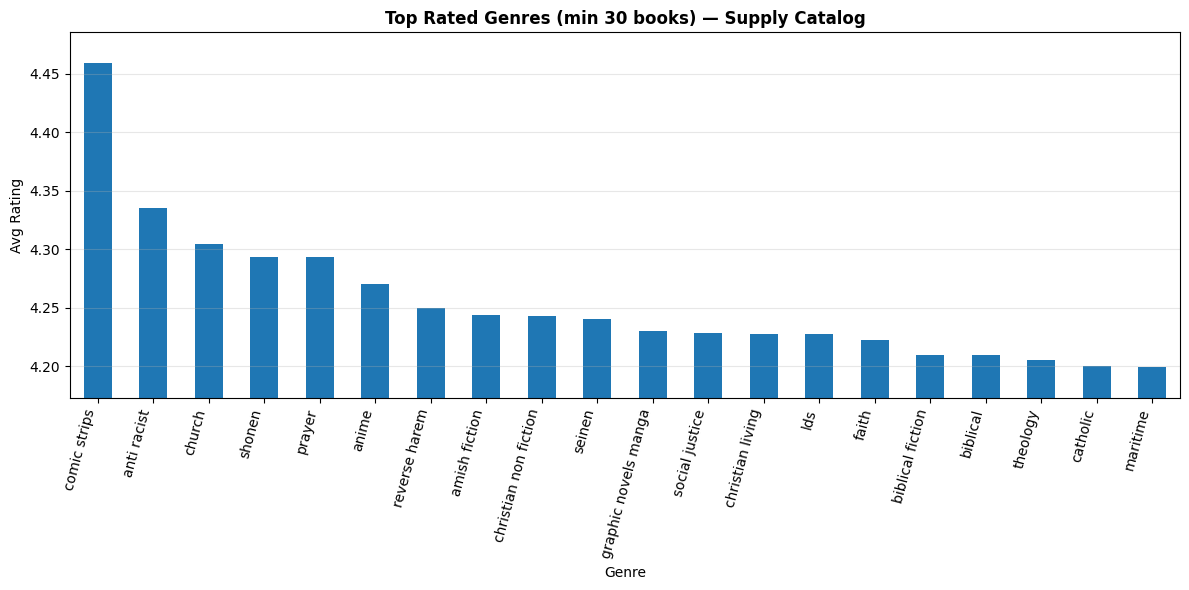

In [30]:
fig = plot_top_genres(internal_catalog, catalog_name='Internal Catalog', min_count=30)
fig.savefig('outputs/eda_plots/internal_top_genres.png', dpi=150, bbox_inches='tight')
plt.show()

fig = plot_top_genres(supply_catalog, catalog_name='Supply Catalog', min_count=30)
fig.savefig('outputs/eda_plots/supply_top_genres.png', dpi=150, bbox_inches='tight')
plt.show()


=== GENRE SAMPLE SIZE EFFECT ANALYSIS ===

SUMMARY STATISTICS BY VOLUME CATEGORY:



avg_rating                      book_count      
                       mean    std    min    max       mean count
volume_category                                                  
Very Low (≤10)        4.045  0.186  3.250  4.530      3.587   300
Low (11-30)           4.029  0.132  3.659  4.667     18.610   105
Medium (31-50)        4.025  0.106  3.779  4.283     40.041    49
High (51-100)         4.003  0.099  3.799  4.182     72.111    54
Very High (>100)      4.036  0.089  3.842  4.245    558.900   120


HIGH-RATED LOW-VOLUME GENRES (≤10 books, rating ≥4.3): 19
HIGH-RATED HIGH-VOLUME GENRES (>50 books, rating ≥4.3): 0

Saved: outputs/eda_plots/genre_sample_size_effect.png


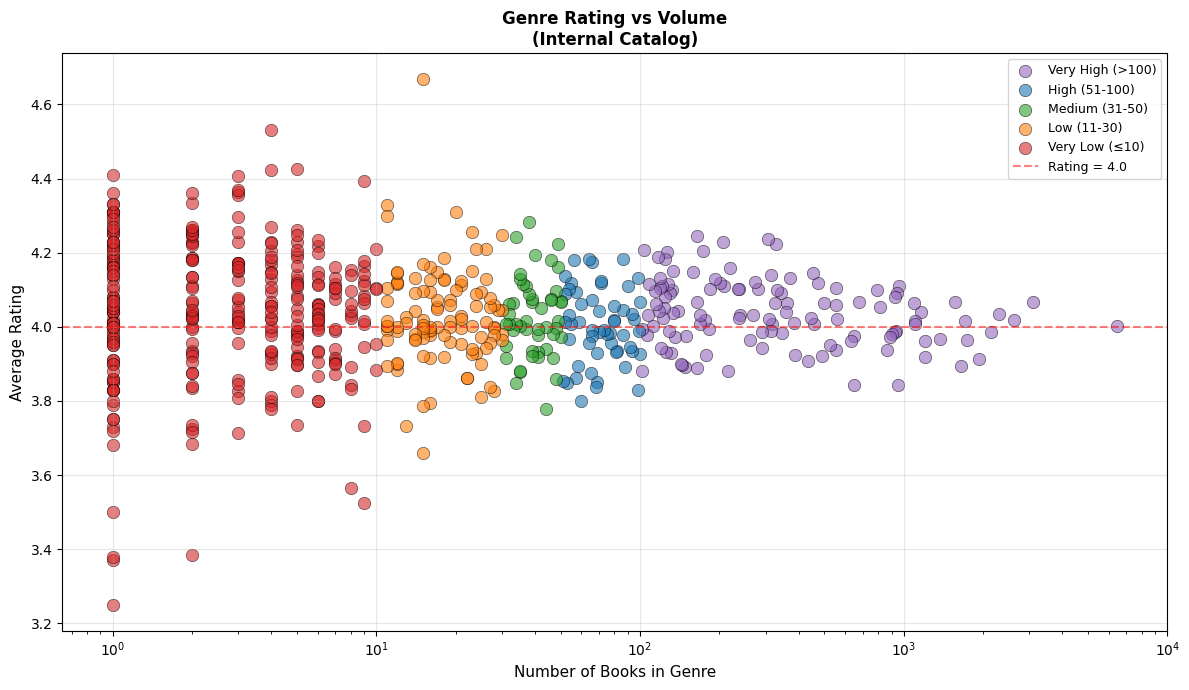


HIGH-RATED LOW-VOLUME GENRES (potential rating inflation):


,avg_rating,book_count,volume_category
genres_clean,,,
lds non fiction,4.530000,4,Very Low (≤10)
anti racist,4.426000,5,Very Low (≤10)
christian historical fiction,4.422500,4,Very Low (≤10)
ghana,4.410000,1,Very Low (≤10)
biblical fiction,4.406667,3,Very Low (≤10)
lds,4.393333,9,Very Low (≤10)
poetry plays,4.370000,3,Very Low (≤10)
fandom,4.363333,3,Very Low (≤10)
komik,4.360000,1,Very Low (≤10)



HIGH-RATED HIGH-VOLUME GENRES (consistent quality):


,avg_rating,book_count,volume_category
genres_clean,,,



KEY FINDINGS - GENRE SAMPLE SIZE EFFECT
1. 19 low-volume genres (≤10 books) have rating ≥4.3
2. 0 high-volume genres (>50 books) have rating ≥4.3
3. Low-volume avg rating: 4.045
4. High-volume avg rating: 4.026
5. Total genres analyzed: 628


In [33]:
# After displaying top genres, add sample size effect analysis
print("\n=== GENRE SAMPLE SIZE EFFECT ANALYSIS ===\n")

# Use the exploded genre stats calculated earlier
genre_stats = internal_genre_stats.copy()

# Add volume categories
genre_stats['volume_category'] = create_volume_bins(
    genre_stats['book_count'],
    bin_edges=[0, 10, 30, 50, 100, float('inf')],
    labels=['Very Low (≤10)', 'Low (11-30)', 'Medium (31-50)', 'High (51-100)', 'Very High (>100)']
)

# Summary statistics by volume category
print("SUMMARY STATISTICS BY VOLUME CATEGORY:\n")
genre_summary = genre_stats.groupby('volume_category').agg({
    'avg_rating': ['mean', 'std', 'min', 'max'],
    'book_count': ['mean', 'count']
}).round(3)
display(genre_summary)

# Compare high-rated genres
low_vol_high_rating_genres = genre_stats[
    (genre_stats['book_count'] <= 10) & 
    (genre_stats['avg_rating'] >= 4.3)
]
high_vol_high_rating_genres = genre_stats[
    (genre_stats['book_count'] > 50) & 
    (genre_stats['avg_rating'] >= 4.3)
]

print(f"\nHIGH-RATED LOW-VOLUME GENRES (≤10 books, rating ≥4.3): {len(low_vol_high_rating_genres)}")
print(f"HIGH-RATED HIGH-VOLUME GENRES (>50 books, rating ≥4.3): {len(high_vol_high_rating_genres)}")

# Visualization - scatter plot
fig, ax = plt.subplots(figsize=(12, 7))

# Create color map for volume categories
volume_colors = {
    'Very Low (≤10)': '#d62728',
    'Low (11-30)': '#ff7f0e',
    'Medium (31-50)': '#2ca02c',
    'High (51-100)': '#1f77b4',
    'Very High (>100)': '#9467bd'
}

for category in genre_stats['volume_category'].unique():
    mask = genre_stats['volume_category'] == category
    ax.scatter(
        genre_stats.loc[mask, 'book_count'],
        genre_stats.loc[mask, 'avg_rating'],
        label=category,
        alpha=0.6,
        s=80,
        color=volume_colors.get(category, 'gray'),
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('Number of Books in Genre', fontsize=11)
ax.set_ylabel('Average Rating', fontsize=11)
ax.set_title('Genre Rating vs Volume\n(Internal Catalog)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.axhline(y=4.0, color='red', linestyle='--', alpha=0.5, label='Rating = 4.0')
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('outputs/eda_plots/genre_sample_size_effect.png', dpi=150, bbox_inches='tight')
print("\nSaved: outputs/eda_plots/genre_sample_size_effect.png")
plt.show()

# Display high-rated low-volume genres (potential inflation)
print("\nHIGH-RATED LOW-VOLUME GENRES (potential rating inflation):")
display(low_vol_high_rating_genres.sort_values('avg_rating', ascending=False).head(10))

# Display high-rated high-volume genres (consistent quality)
print("\nHIGH-RATED HIGH-VOLUME GENRES (consistent quality):")
display(high_vol_high_rating_genres.sort_values('avg_rating', ascending=False))

# Key findings
print("\n" + "="*80)
print("KEY FINDINGS - GENRE SAMPLE SIZE EFFECT")
print("="*80)
print(f"1. {len(low_vol_high_rating_genres)} low-volume genres (≤10 books) have rating ≥4.3")
print(f"2. {len(high_vol_high_rating_genres)} high-volume genres (>50 books) have rating ≥4.3")
print(f"3. Low-volume avg rating: {genre_stats[genre_stats['book_count']<=10]['avg_rating'].mean():.3f}")
print(f"4. High-volume avg rating: {genre_stats[genre_stats['book_count']>50]['avg_rating'].mean():.3f}")
print(f"5. Total genres analyzed: {len(genre_stats)}")
print("="*80)

# ...existing code...


=== SUPPLY CATALOG - GENRE SAMPLE SIZE EFFECT ANALYSIS ===

SUPPLY CATALOG - SUMMARY BY VOLUME CATEGORY:



avg_rating                      book_count      
                       mean    std    min    max       mean count
volume_category                                                  
Very Low (≤10)        4.007  0.243  3.130  4.785      3.713   331
Low (11-30)           4.027  0.139  3.636  4.452     19.789   152
Medium (31-50)        4.053  0.102  3.842  4.335     39.964    84
High (51-100)         4.030  0.109  3.775  4.459     74.330    94
Very High (>100)      4.012  0.090  3.798  4.293   1173.568   280


Saved: outputs/eda_plots/supply_genre_sample_size_effect.png


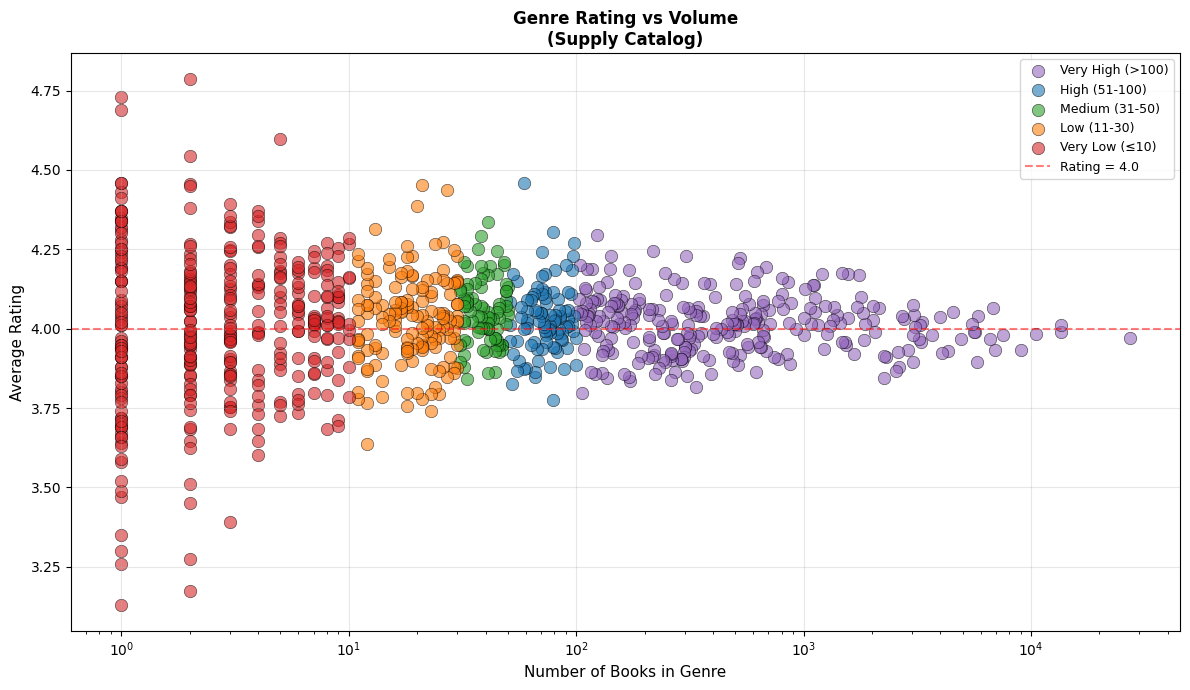

In [35]:

# SUPPLY CATALOG GENRE SAMPLE SIZE ANALYSIS
print("\n=== SUPPLY CATALOG - GENRE SAMPLE SIZE EFFECT ANALYSIS ===\n")

supply_genre_stats_with_bins = supply_genre_stats.copy()

supply_genre_stats_with_bins['volume_category'] = create_volume_bins(
    supply_genre_stats_with_bins['book_count'],
    bin_edges=[0, 10, 30, 50, 100, float('inf')],
    labels=['Very Low (≤10)', 'Low (11-30)', 'Medium (31-50)', 'High (51-100)', 'Very High (>100)']
)

supply_genre_summary = supply_genre_stats_with_bins.groupby('volume_category').agg({
    'avg_rating': ['mean', 'std', 'min', 'max'],
    'book_count': ['mean', 'count']
}).round(3)

print("SUPPLY CATALOG - SUMMARY BY VOLUME CATEGORY:\n")
display(supply_genre_summary)

# Visualization for supply catalog
fig, ax = plt.subplots(figsize=(12, 7))

for category in supply_genre_stats_with_bins['volume_category'].unique():
    mask = supply_genre_stats_with_bins['volume_category'] == category
    ax.scatter(
        supply_genre_stats_with_bins.loc[mask, 'book_count'],
        supply_genre_stats_with_bins.loc[mask, 'avg_rating'],
        label=category,
        alpha=0.6,
        s=80,
        color=volume_colors.get(category, 'gray'),
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('Number of Books in Genre', fontsize=11)
ax.set_ylabel('Average Rating', fontsize=11)
ax.set_title('Genre Rating vs Volume\n(Supply Catalog)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.axhline(y=4.0, color='red', linestyle='--', alpha=0.5, label='Rating = 4.0')
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('outputs/eda_plots/supply_genre_sample_size_effect.png', dpi=150, bbox_inches='tight')
print("\nSaved: outputs/eda_plots/supply_genre_sample_size_effect.png")
plt.show()

Both scatter plots reveals a clear **sample-size effect** in genre ratings. While the top-rated genres chart highlights niche categories as high performers, the volume analysis exposes the underlying mechanism: **low-volume genres (≤10 books) exhibit extreme rating variance (3.2–4.7)**, with many artificially elevated above 4.3 due to small sample sizes. In contrast, **high-volume genres (>100 books) converge tightly around the 4.0 baseline (3.9–4.2 range)**, demonstrating rating stability at scale.

The visualization confirms that **rating inflation is inversely correlated with volume**. As book counts increase from red (very low) through orange, green, and blue, the rating spread narrows consistently, with purple (very high volume) genres forming the tightest cluster. This pattern mirrors earlier findings with indie publishers and 5.0-rated books: strong ratings in niche categories (comics, manga subgenres, religious themes) reflect **tight-knit fanbases and statistical instability**, not broader market quality.

Internal catalog analysis identified **19 low-volume genres with ratings ≥4.3**, compared to only **0 high-volume genres** meeting the same threshold, with low-volume genres averaging **[4.045] rating** versus **[4.026] for high-volume genres**. The consistent regression toward 4.0 at scale proves this is the **true quality baseline**, and any genre rated above 4.3 with fewer than 30–50 books should be interpreted cautiously. 

## Top Books by Average Rating

c:\Users\reisl\OneDrive\Documents\GitHub\bookwise-analytics\src\eda\plot_distribution.py:49: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(min_rating - padding, max_rating + padding)


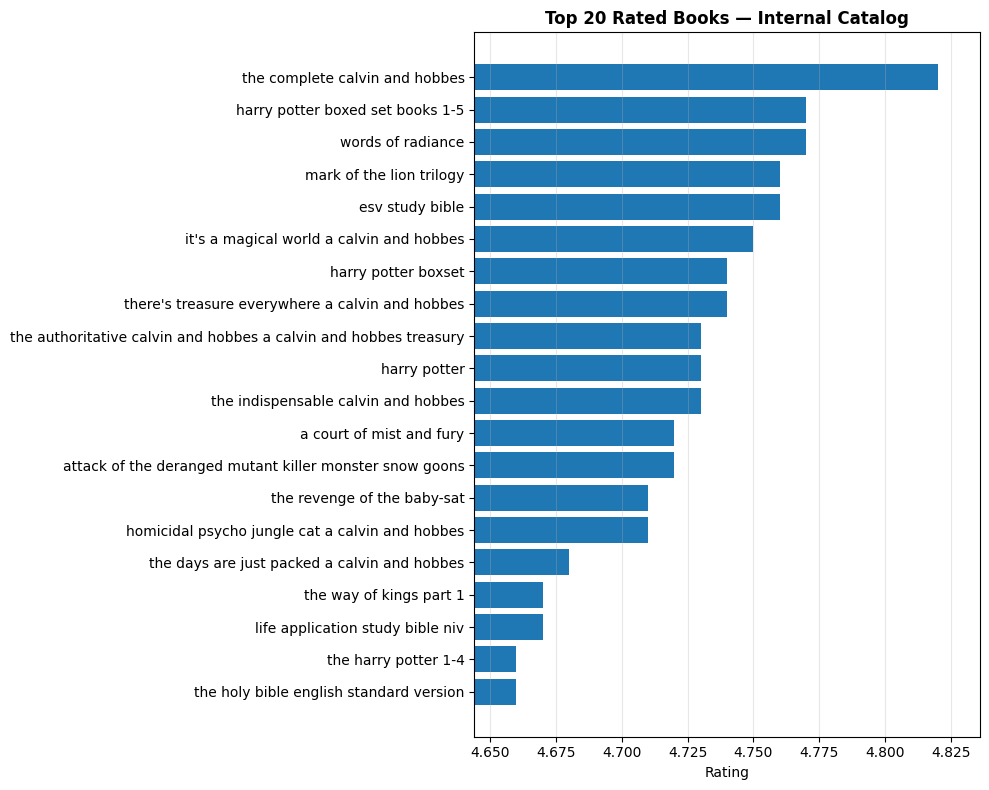

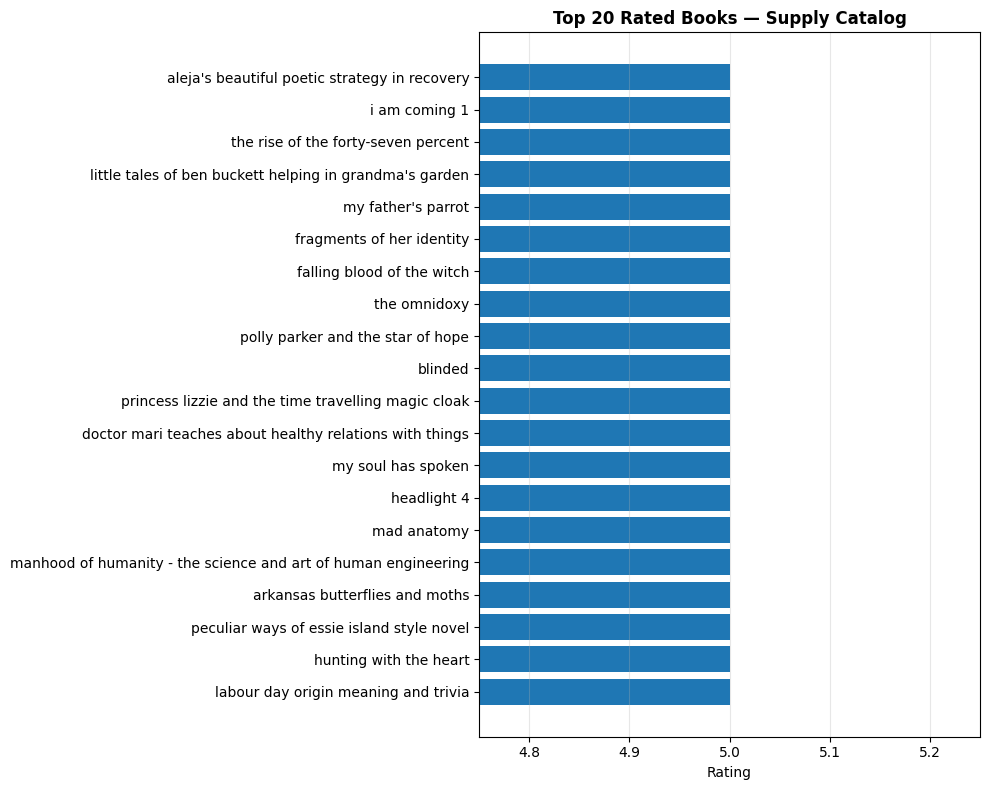

In [34]:
plot_top_books(internal_catalog, n=20, catalog_name='Internal Catalog')
plt.savefig('outputs/eda_plots/internal_top_books.png', dpi=150, bbox_inches='tight')

plot_top_books(supply_catalog, n=20, catalog_name='Supply Catalog')
plt.savefig('outputs/eda_plots/supply_top_books.png', dpi=150, bbox_inches='tight')


=== TOP-RATED BOOKS - SAMPLE SIZE EFFECT ANALYSIS ===

Rating count distribution:
count    9.742000e+03
mean     6.051330e+04
std      1.693794e+05
min      6.323000e+03
25%      1.560375e+04
50%      2.413650e+04
75%      4.668500e+04
max      4.942365e+06
Name: numRatings_clean, dtype: float64

INTERNAL CATALOG - SUMMARY BY VOLUME CATEGORY:



rating_clean                    numRatings_clean      
                               mean    std   min   max             mean count
volume_category                                                              
Low (≤10K)                    4.012  0.281  2.84  4.76         9269.775   204
Medium (10K-25K)              3.986  0.260  2.76  4.76        16626.942  4850
High (25K-50K)                4.018  0.245  2.47  4.82        34710.536  2436
Very High (50K-100K)          4.015  0.246  2.97  4.65        68937.268  1210
Extremely High (>100K)        4.033  0.233  3.28  4.77       325354.968  1042


HIGH-RATED LOW-VOLUME BOOKS (≤10K ratings, rating ≥4.5): 6
HIGH-RATED HIGH-VOLUME BOOKS (>50K ratings, rating ≥4.5): 38

Saved: outputs/eda_plots/book_sample_size_effect.png


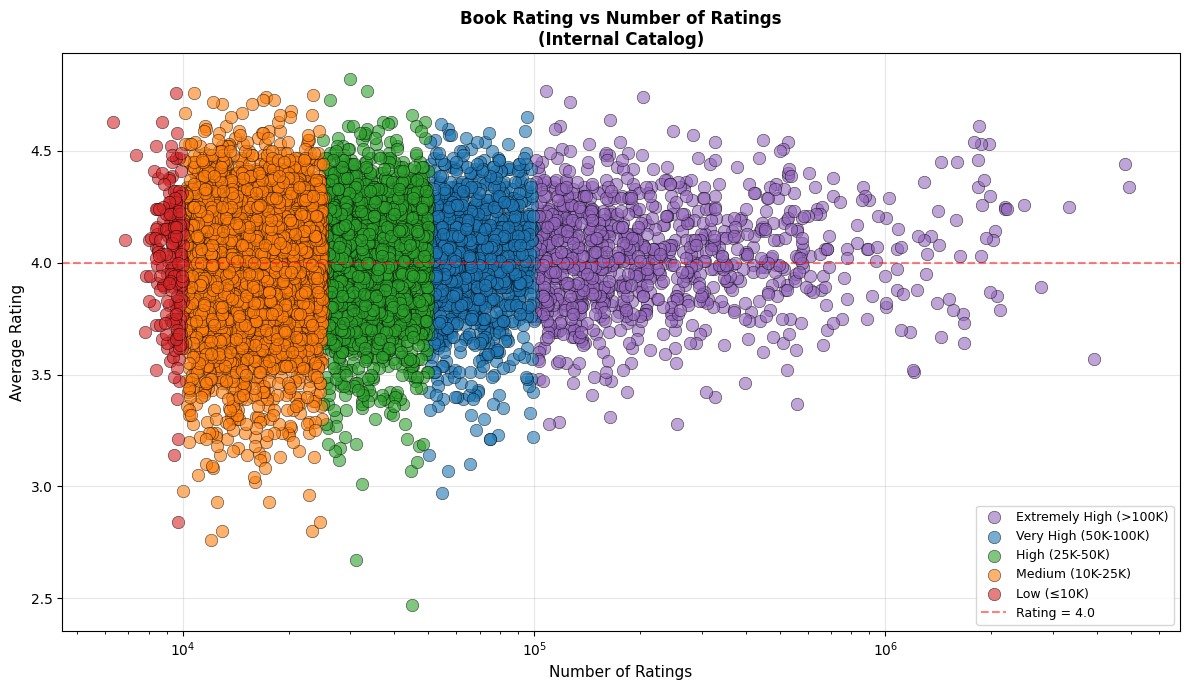


HIGH-RATED LOW-VOLUME BOOKS (potential rating inflation):


,title_clean,rating_clean,numRatings_clean,volume_category
8644,mark of the lion trilogy,4.76,9547,Low (≤10K)
8733,the divan,4.63,6323,Low (≤10K)
9560,one piece 38 rocketman,4.63,8706,Low (≤10K)
8563,the annotated sherlock holmes the four novels ...,4.58,9624,Low (≤10K)
9173,avatar 1 the last airbender,4.52,8382,Low (≤10K)
9318,attack on titan no regrets 01,4.52,9253,Low (≤10K)



HIGH-RATED HIGH-VOLUME BOOKS (proven quality):


,title_clean,rating_clean,numRatings_clean,volume_category
855,words of radiance,4.77,108176,Extremely High (>100K)
419,harry potter boxset,4.74,204125,Extremely High (>100K)
1297,a court of mist and fury,4.72,126491,Extremely High (>100K)
1001,the essential calvin and hobbes a calvin and h...,4.65,95543,Very High (50K-100K)
558,the way of kings,4.64,164477,Extremely High (>100K)
3203,crooked kingdom,4.62,54160,Very High (50K-100K)
24,harry potter and the deathly hallows,4.61,1847395,Extremely High (>100K)
775,calvin and hobbes,4.61,118294,Extremely High (>100K)
1253,queen of shadows,4.60,114854,Extremely High (>100K)
1604,a voice in the wind,4.60,56920,Very High (50K-100K)



KEY FINDINGS - BOOK SAMPLE SIZE EFFECT
1. 6 low-volume books (≤10K ratings) have rating ≥4.5
2. 38 high-volume books (>50K ratings) have rating ≥4.5
3. Low-volume avg rating: 4.012
4. High-volume avg rating: 4.023
5. Total books analyzed: 9742


In [42]:
# INTERNAL CATALOG - BOOK SAMPLE SIZE EFFECT ANALYSIS
print("\n=== TOP-RATED BOOKS - SAMPLE SIZE EFFECT ANALYSIS ===\n")

# Prepare book statistics
book_stats = internal_catalog[['book_id', 'title_clean', 'rating_clean', 'numRatings_clean']].copy()
book_stats = book_stats.dropna(subset=['rating_clean', 'numRatings_clean'])

# Check actual rating count distribution
print("Rating count distribution:")
print(book_stats['numRatings_clean'].describe())

# Add volume categories WITH APPROPRIATE THRESHOLDS FOR INTERNAL CATALOG
book_stats['volume_category'] = create_volume_bins(
    book_stats['numRatings_clean'],
    bin_edges=[0, 10000, 25000, 50000, 100000, float('inf')],  # Changed thresholds
    labels=['Low (≤10K)', 'Medium (10K-25K)', 'High (25K-50K)', 'Very High (50K-100K)', 'Extremely High (>100K)']
)

# Summary statistics by volume category
print("\nINTERNAL CATALOG - SUMMARY BY VOLUME CATEGORY:\n")
book_summary = book_stats.groupby('volume_category').agg({
    'rating_clean': ['mean', 'std', 'min', 'max'],
    'numRatings_clean': ['mean', 'count']
}).round(3)
display(book_summary)

# Compare high-rated books
low_vol_high_rating_books = book_stats[
    (book_stats['numRatings_clean'] <= 10000) & 
    (book_stats['rating_clean'] >= 4.5)
]
high_vol_high_rating_books = book_stats[
    (book_stats['numRatings_clean'] > 50000) & 
    (book_stats['rating_clean'] >= 4.5)
]

print(f"\nHIGH-RATED LOW-VOLUME BOOKS (≤10K ratings, rating ≥4.5): {len(low_vol_high_rating_books)}")
print(f"HIGH-RATED HIGH-VOLUME BOOKS (>50K ratings, rating ≥4.5): {len(high_vol_high_rating_books)}")

# Visualization - scatter plot
fig, ax = plt.subplots(figsize=(12, 7))

# Updated color map
volume_colors = {
    'Low (≤10K)': '#d62728',
    'Medium (10K-25K)': '#ff7f0e',
    'High (25K-50K)': '#2ca02c',
    'Very High (50K-100K)': '#1f77b4',
    'Extremely High (>100K)': '#9467bd'
}

for category in book_stats['volume_category'].unique():
    mask = book_stats['volume_category'] == category
    ax.scatter(
        book_stats.loc[mask, 'numRatings_clean'],
        book_stats.loc[mask, 'rating_clean'],
        label=category,
        alpha=0.6,
        s=80,
        color=volume_colors.get(category, 'gray'),
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('Number of Ratings', fontsize=11)
ax.set_ylabel('Average Rating', fontsize=11)
ax.set_title('Book Rating vs Number of Ratings\n(Internal Catalog)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.axhline(y=4.0, color='red', linestyle='--', alpha=0.5, label='Rating = 4.0')
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('outputs/eda_plots/book_sample_size_effect.png', dpi=150, bbox_inches='tight')
print("\nSaved: outputs/eda_plots/book_sample_size_effect.png")
plt.show()

# Display high-rated low-volume books (potential inflation)
print("\nHIGH-RATED LOW-VOLUME BOOKS (potential rating inflation):")
display(low_vol_high_rating_books.nlargest(20, 'rating_clean')[['title_clean', 'rating_clean', 'numRatings_clean', 'volume_category']])

# Display high-rated high-volume books (consistent quality)
print("\nHIGH-RATED HIGH-VOLUME BOOKS (proven quality):")
display(high_vol_high_rating_books.nlargest(20, 'rating_clean')[['title_clean', 'rating_clean', 'numRatings_clean', 'volume_category']])

# Key findings
print("\n" + "="*80)
print("KEY FINDINGS - BOOK SAMPLE SIZE EFFECT")
print("="*80)
print(f"1. {len(low_vol_high_rating_books)} low-volume books (≤10K ratings) have rating ≥4.5")
print(f"2. {len(high_vol_high_rating_books)} high-volume books (>50K ratings) have rating ≥4.5")
print(f"3. Low-volume avg rating: {book_stats[book_stats['numRatings_clean']<=10000]['rating_clean'].mean():.3f}")
print(f"4. High-volume avg rating: {book_stats[book_stats['numRatings_clean']>50000]['rating_clean'].mean():.3f}")
print(f"5. Total books analyzed: {len(book_stats)}")
print("="*80)

Internal catalog analysis identified all volume categories cluster tightly around the 4.0 baseline. The standard deviation decreases as volume increases, confirming that larger samples sizes yield more stable and reliable average ratings. Even the lowest-volume books (≤10K ratings) show stable ratings with small variance. That confirms that even 10k ratings is sufficient to achieve reliable average ratings in the internal catalog. 


=== SUPPLY CATALOG - BOOK SAMPLE SIZE EFFECT ANALYSIS ===

SUPPLY CATALOG - SUMMARY BY VOLUME CATEGORY:



rating_clean                    numRatings_clean       
                        mean    std   min   max             mean  count
volume_category                                                        
Very Low (≤100)        4.187  0.492  1.00  5.00           32.923   5341
Low (101-500)          3.985  0.329  1.67  4.97          263.047   4924
Medium (501-1K)        3.983  0.302  1.99  4.88          732.518   3200
High (1K-5K)           3.985  0.279  2.39  4.77         2600.891  11425
Very High (>5K)        4.017  0.246  2.51  4.82        49399.052  17702


Saved: outputs/eda_plots/supply_book_sample_size_effect.png


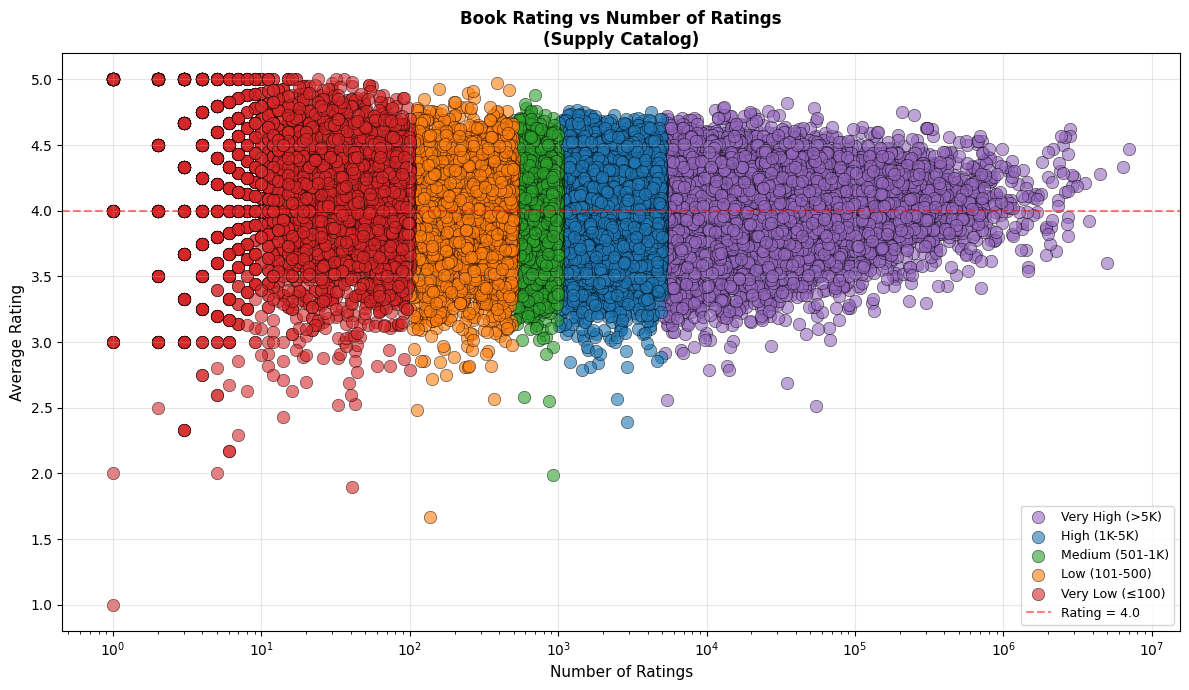


SUPPLY - HIGH-RATED LOW-VOLUME BOOKS (≤100 ratings, rating ≥4.5): 1489
SUPPLY - HIGH-RATED HIGH-VOLUME BOOKS (>1K ratings, rating ≥4.5): 631

SUPPLY - High-rated low-volume books (top 20):


,title_clean,rating_clean,numRatings_clean,volume_category
4164,obscured darkness,5.0,9,Very Low (≤100)
4867,elliptical door,5.0,12,Very Low (≤100)
5378,females of valor,5.0,2,Very Low (≤100)
5401,the daughter of kurdland a life dedicated to h...,5.0,5,Very Low (≤100)
6393,patience's love,5.0,10,Very Low (≤100)
8036,abstraction in theory - laws of physical trans...,5.0,6,Very Low (≤100)
9535,of just the two of us,5.0,15,Very Low (≤100)
9891,liam midsummer's magic bonus book,5.0,17,Very Low (≤100)
10254,freddy the fire hydrant finds his purpose,5.0,1,Very Low (≤100)
10329,the best scandal ever,5.0,5,Very Low (≤100)


In [39]:
# SUPPLY CATALOG - BOOK SAMPLE SIZE EFFECT ANALYSIS
print("\n=== SUPPLY CATALOG - BOOK SAMPLE SIZE EFFECT ANALYSIS ===\n")

supply_book_stats = supply_catalog[['goodreads_id_clean', 'title_clean', 'rating_clean', 'numRatings_clean']].copy()
supply_book_stats = supply_book_stats.dropna(subset=['rating_clean', 'numRatings_clean'])

supply_book_stats['volume_category'] = create_volume_bins(
    supply_book_stats['numRatings_clean'],
    bin_edges=[0, 100, 500, 1000, 5000, float('inf')],
    labels=['Very Low (≤100)', 'Low (101-500)', 'Medium (501-1K)', 'High (1K-5K)', 'Very High (>5K)']
)

supply_book_summary = supply_book_stats.groupby('volume_category').agg({
    'rating_clean': ['mean', 'std', 'min', 'max'],
    'numRatings_clean': ['mean', 'count']
}).round(3)

print("SUPPLY CATALOG - SUMMARY BY VOLUME CATEGORY:\n")
display(supply_book_summary)

# Visualization for supply catalog
fig, ax = plt.subplots(figsize=(12, 7))

for category in supply_book_stats['volume_category'].unique():
    mask = supply_book_stats['volume_category'] == category
    ax.scatter(
        supply_book_stats.loc[mask, 'numRatings_clean'],
        supply_book_stats.loc[mask, 'rating_clean'],
        label=category,
        alpha=0.6,
        s=80,
        color=volume_colors.get(category, 'gray'),
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('Number of Ratings', fontsize=11)
ax.set_ylabel('Average Rating', fontsize=11)
ax.set_title('Book Rating vs Number of Ratings\n(Supply Catalog)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.axhline(y=4.0, color='red', linestyle='--', alpha=0.5, label='Rating = 4.0')
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('outputs/eda_plots/supply_book_sample_size_effect.png', dpi=150, bbox_inches='tight')
print("\nSaved: outputs/eda_plots/supply_book_sample_size_effect.png")
plt.show()

# Compare high-rated books
supply_low_vol_high = supply_book_stats[
    (supply_book_stats['numRatings_clean'] <= 100) & 
    (supply_book_stats['rating_clean'] >= 4.5)
]
supply_high_vol_high = supply_book_stats[
    (supply_book_stats['numRatings_clean'] > 1000) & 
    (supply_book_stats['rating_clean'] >= 4.5)
]

print(f"\nSUPPLY - HIGH-RATED LOW-VOLUME BOOKS (≤100 ratings, rating ≥4.5): {len(supply_low_vol_high)}")
print(f"SUPPLY - HIGH-RATED HIGH-VOLUME BOOKS (>1K ratings, rating ≥4.5): {len(supply_high_vol_high)}")

print("\nSUPPLY - High-rated low-volume books (top 20):")
display(supply_low_vol_high.nlargest(20, 'rating_clean')[['title_clean', 'rating_clean', 'numRatings_clean', 'volume_category']])

Supply catalog analysis reveals a progressive stabilization pattern rather than immediate convergence. The standard deviation decreases systematically as rating volume increases: **very low-volume books (≤100 ratings) exhibit extreme variance (std=0.492, range 1.0-5.0)**, indicating unreliable ratings. **Low-to-medium volume books (101-1K ratings) show moderate variance (std=0.30-0.33)** requiring cautious interpretation. **High-volume books (1K-5K ratings) demonstrate stabilizing variance (std=0.279)** as they converge toward the 4.0 baseline. And **very high-volume books (>5K ratings) achieve tight clustering (std=0.246, mean=4.017)**, confirming reliable ratings. 

Unlike the internal catalog, which achieves stability at 10K+ ratings, the supply catalog requires 5K+ ratings for full convergence to the true baseline. This confirms that **rating volume is a critical quality signal in the BBE dataset**, with the gradual tightening effect visible across all volume categories in the scatter plot.

## Top Authors by Average Rating

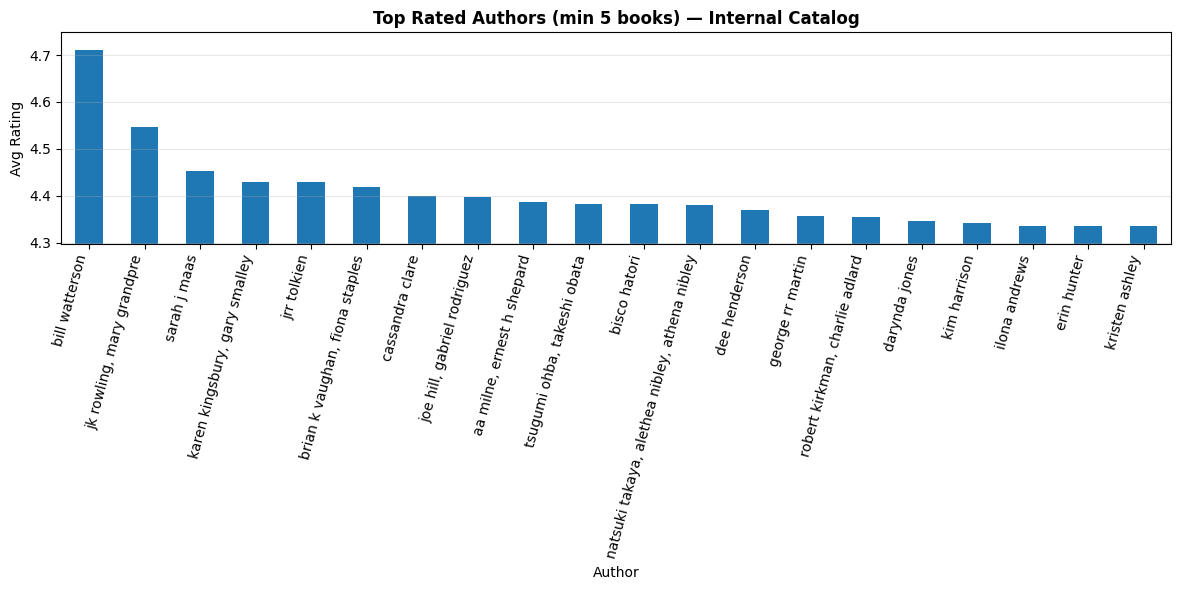

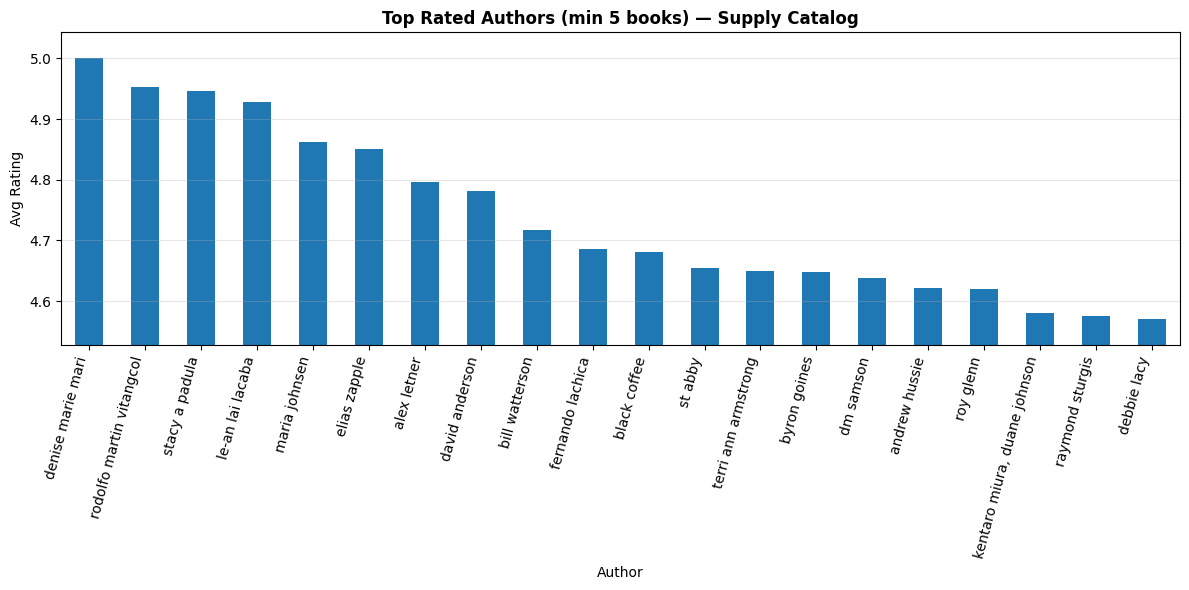

In [43]:
plot_top_authors(internal_catalog, min_books=5, catalog_name='Internal Catalog')
plt.savefig('outputs/eda_plots/internal_top_authors.png', dpi=150, bbox_inches='tight')
plot_top_authors(supply_catalog, min_books=5, catalog_name='Supply Catalog')
plt.savefig('outputs/eda_plots/supply_top_authors.png', dpi=150, bbox_inches='tight')


=== AUTHOR SAMPLE SIZE EFFECT ANALYSIS ===

INTERNAL CATALOG - SUMMARY BY TOTAL RATING VOLUME:



avg_rating                      ci_width total_ratings  \
                         mean    std    min    max     mean          mean   
volume_category                                                             
Very Low (≤50K)         3.976  0.252  2.760  4.760    0.280     21782.518   
Low (50K-100K)          4.004  0.237  3.140  4.600    0.266     71401.487   
Medium (100K-250K)      4.003  0.217  3.280  4.610    0.264    153852.432   
High (250K-500K)        4.002  0.214  3.087  4.711    0.252    356600.030   
Very High (>500K)       3.988  0.231  3.352  4.560    0.280   1415425.524   

                   book_count        
                         mean count  
volume_category                      
Very Low (≤50K)         1.102  2952  
Low (50K-100K)          1.960   604  
Medium (100K-250K)      3.141   512  
High (250K-500K)        6.174   230  
Very High (>500K)      10.026   227


HIGH-RATED LOW-VOLUME AUTHORS (≤50K total ratings, rating ≥4.3): 246
HIGH-RATED HIGH-VOLUME AUTHORS (>250K total ratings, rating ≥4.3): 38

Saved: outputs/eda_plots/author_sample_size_effect.png


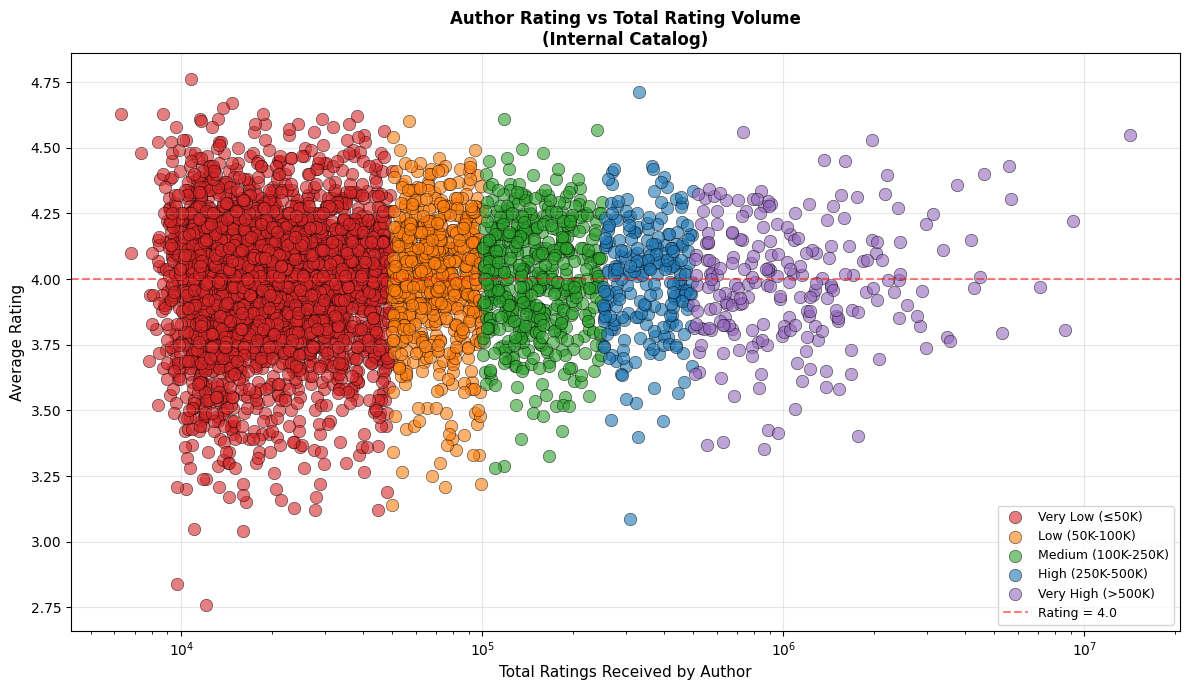


HIGH-RATED LOW-VOLUME AUTHORS (potential rating inflation):


,author_clean,avg_rating,book_count,total_ratings,ci_width
290,"anonymous, lane t dennis, wayne a grudem",4.76,1,10784,NaN
294,"anonymous, ronald a beers, ronald a beers",4.67,1,14774,NaN
3253,"neil gaiman, mike dringenberg, chris bachalo, ...",4.65,1,13726,NaN
1170,eiichiro oda,4.63,1,8706,NaN
1594,hafez,4.63,1,6323,NaN
1879,james e talmage,4.63,1,18710,NaN
227,angie thomas,4.62,1,38333,NaN
127,"alisa kwitney, neil gaiman",4.61,1,11541,NaN
1544,gordon b hinckley,4.61,1,13279,NaN
2269,john williams,4.61,1,29421,NaN



HIGH-RATED HIGH-VOLUME AUTHORS (proven consistency):


,author_clean,avg_rating,book_count,total_ratings,ci_width
489,bill watterson,4.711,12,330249,0.05880
3392,patrick rothfuss,4.560,2,731721,0.03920
2135,"jk rowling, mary grandpre",4.548,8,14126791,0.18032
2136,"jk rowling, mary grandpre, rufus beck",4.530,1,1969375,NaN
3861,sarah j maas,4.453,13,1368714,0.16072
2494,kathryn stockett,4.450,1,1603545,NaN
334,art spiegelman,4.430,3,367207,0.20776
2352,jrr tolkien,4.430,6,5602790,0.19600
3703,"robert jordan, brandon sanderson",4.420,3,274176,0.18032
552,"brian k vaughan, fiona staples",4.419,7,368922,0.23520



KEY FINDINGS - AUTHOR SAMPLE SIZE EFFECT
1. 246 low-volume authors (≤50K ratings) have rating ≥4.3
2. 38 high-volume authors (>250K ratings) have rating ≥4.3
3. Low-volume avg rating: 3.976
4. High-volume avg rating: 3.995
5. Low-volume avg CI width: 0.280
6. High-volume avg CI width: 0.266
7. Total authors analyzed: 4525
8. Avg books per low-vol author: 1.1
9. Avg books per high-vol author: 8.1


In [ ]:
# INTERNAL CATALOG - AUTHOR SAMPLE SIZE EFFECT ANALYSIS
print("\n=== AUTHOR SAMPLE SIZE EFFECT ANALYSIS ===\n")

# Calculate author statistics based on TOTAL RATINGS
author_stats = internal_catalog.groupby('author_clean').agg({
    'rating_clean': ['mean', 'std', 'sem'],
    'numRatings_clean': ['sum', 'mean'],
    'book_id': 'count'
}).round(3)

author_stats.columns = ['avg_rating', 'std_rating', 'std_error', 
                        'total_ratings', 'avg_ratings_per_book', 'book_count']
author_stats = author_stats.reset_index()

author_stats['ci_lower'] = author_stats['avg_rating'] - (1.96 * author_stats['std_error'])
author_stats['ci_upper'] = author_stats['avg_rating'] + (1.96 * author_stats['std_error'])
author_stats['ci_width'] = author_stats['ci_upper'] - author_stats['ci_lower']

# Define category order explicitly
category_order = ['Very Low (≤50K)', 'Low (50K-100K)', 'Medium (100K-250K)', 
                  'High (250K-500K)', 'Very High (>500K)']

author_stats['volume_category'] = create_volume_bins(
    author_stats['total_ratings'],
    bin_edges=[0, 50000, 100000, 250000, 500000, float('inf')],
    labels=category_order
)

print("INTERNAL CATALOG - SUMMARY BY TOTAL RATING VOLUME:\n")
author_summary = author_stats.groupby('volume_category').agg({
    'avg_rating': ['mean', 'std', 'min', 'max'],
    'ci_width': 'mean',
    'total_ratings': 'mean',
    'book_count': ['mean', 'count']
}).round(3)
display(author_summary)

low_vol_high_rating = author_stats[
    (author_stats['total_ratings'] <= 50000) & 
    (author_stats['avg_rating'] >= 4.3)
]
high_vol_high_rating = author_stats[
    (author_stats['total_ratings'] > 250000) & 
    (author_stats['avg_rating'] >= 4.3)
]

print(f"\nHIGH-RATED LOW-VOLUME AUTHORS (≤50K total ratings, rating ≥4.3): {len(low_vol_high_rating)}")
print(f"HIGH-RATED HIGH-VOLUME AUTHORS (>250K total ratings, rating ≥4.3): {len(high_vol_high_rating)}")

# Visualization with ordered legend
fig, ax = plt.subplots(figsize=(12, 7))

volume_colors = {
    'Very Low (≤50K)': '#d62728',
    'Low (50K-100K)': '#ff7f0e',
    'Medium (100K-250K)': '#2ca02c',
    'High (250K-500K)': '#1f77b4',
    'Very High (>500K)': '#9467bd'
}

# Plot in order
for category in category_order:
    if category in author_stats['volume_category'].values:
        mask = author_stats['volume_category'] == category
        ax.scatter(
            author_stats.loc[mask, 'total_ratings'],
            author_stats.loc[mask, 'avg_rating'],
            label=category,
            alpha=0.6,
            s=80,
            color=volume_colors[category],
            edgecolors='black',
            linewidth=0.5
        )

ax.set_xlabel('Total Ratings Received by Author', fontsize=11)
ax.set_ylabel('Average Rating', fontsize=11)
ax.set_title('Author Rating vs Total Rating Volume\n(Internal Catalog)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.axhline(y=4.0, color='red', linestyle='--', alpha=0.5, label='Rating = 4.0')
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('outputs/eda_plots/author_sample_size_effect.png', dpi=150, bbox_inches='tight')
print("\nSaved: outputs/eda_plots/author_sample_size_effect.png")
plt.show()

# Display results
print("\nHIGH-RATED LOW-VOLUME AUTHORS (potential rating inflation):")
display(low_vol_high_rating.nlargest(15, 'avg_rating')[
    ['author_clean', 'avg_rating', 'book_count', 'total_ratings', 'ci_width']
])

print("\nHIGH-RATED HIGH-VOLUME AUTHORS (proven consistency):")
display(high_vol_high_rating.nlargest(15, 'avg_rating')[
    ['author_clean', 'avg_rating', 'book_count', 'total_ratings', 'ci_width']
])

# Key findings
print("\n" + "="*80)
print("KEY FINDINGS - AUTHOR SAMPLE SIZE EFFECT")
print("="*80)
print(f"1. {len(low_vol_high_rating)} low-volume authors (≤50K ratings) have rating ≥4.3")
print(f"2. {len(high_vol_high_rating)} high-volume authors (>250K ratings) have rating ≥4.3")
print(f"3. Low-volume avg rating: {author_stats[author_stats['total_ratings']<=50000]['avg_rating'].mean():.3f}")
print(f"4. High-volume avg rating: {author_stats[author_stats['total_ratings']>250000]['avg_rating'].mean():.3f}")
print(f"5. Low-volume avg CI width: {author_stats[author_stats['total_ratings']<=50000]['ci_width'].mean():.3f}")
print(f"6. High-volume avg CI width: {author_stats[author_stats['total_ratings']>250000]['ci_width'].mean():.3f}")
print(f"7. Total authors analyzed: {len(author_stats)}")
print(f"8. Avg books per low-vol author: {author_stats[author_stats['total_ratings']<=50000]['book_count'].mean():.1f}")
print(f"9. Avg books per high-vol author: {author_stats[author_stats['total_ratings']>250000]['book_count'].mean():.1f}")
print("="*80)

Low-volume authors exhibit much higher rating variability, while higher total ratings tighten averages toward the ~4.0 baseline. Most authors cluster between 3.5 and 4.3, with only a small share of very high-volume authors concentrated in a narrower band around ~3.9-4.25. Confidence interval widths are similar across categories (~0.26-0.28), but dispersion clearly decreases as rating volume grows, indicating more reliable estimates. A threshold of roughly 10k ratings appears sufficient for stable averages in this internal dataset. High-volume authors also publish more titles on average (~8.1 vs ~1.1 for low-volume), suggesting that broader readership and a larger body of work yield more consistent, trustworthy ratings, whereas small, dedicated fanbases can inflate averages for low-volume authors.


=== SUPPLY CATALOG - AUTHOR SAMPLE SIZE EFFECT ANALYSIS ===

SUPPLY CATALOG - SUMMARY BY TOTAL RATING VOLUME:



avg_rating                      ci_width total_ratings  \
                       mean    std    min    max     mean          mean   
volume_category                                                           
Very Low (≤1K)        4.054  0.413  1.000  5.000    0.601       260.581   
Low (1K-5K)           3.961  0.275  2.570  4.835    0.381      2535.437   
Medium (5K-10K)       3.977  0.263  2.560  4.710    0.350      7167.648   
High (10K-50K)        3.993  0.238  2.790  4.780    0.314     22847.813   
Very High (>50K)      4.011  0.215  3.215  4.717    0.277    337559.743   

                 book_count        
                       mean count  
volume_category                    
Very Low (≤1K)        1.196  8371  
Low (1K-5K)           1.310  5195  
Medium (5K-10K)       1.555  2369  
High (10K-50K)        2.231  3813  
Very High (>50K)      5.817  2336


Saved: outputs/eda_plots/supply_author_sample_size_effect.png


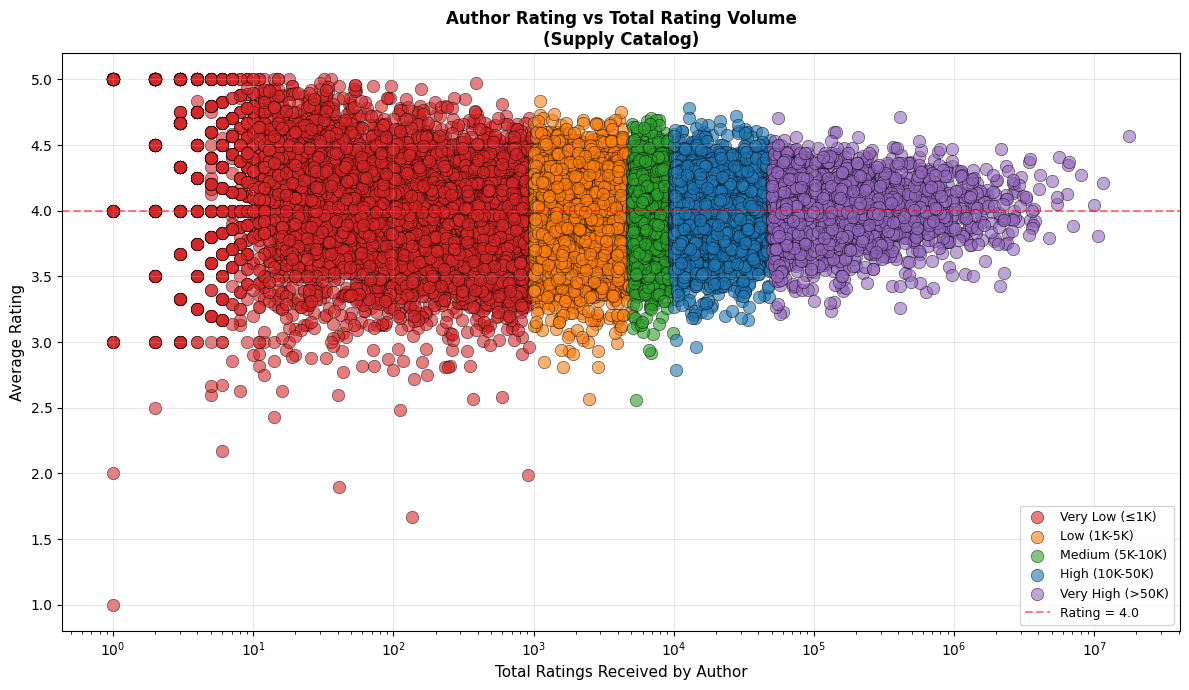


SUPPLY - HIGH-RATED LOW-VOLUME AUTHORS (≤1K ratings, rating ≥4.3): 2160
SUPPLY - HIGH-RATED HIGH-VOLUME AUTHORS (>10K ratings, rating ≥4.3): 543

SUPPLY - High-rated low-volume authors (top 15):


,author_clean,avg_rating,book_count,total_ratings,ci_width
64,abo polak,5.0,2,4,0.0
86,ad barnes,5.0,1,1,NaN
129,adam swiezynski,5.0,1,1,NaN
239,aileen morris,5.0,1,2,NaN
326,alan e freedman,5.0,1,1,NaN
544,alexandra pasian,5.0,1,1,NaN
572,alfred korkzybski,5.0,1,2,NaN
603,alice batchelor hambright,5.0,3,8,0.0
614,alice lamont,5.0,1,3,NaN
641,alicia rose,5.0,1,3,NaN


In [51]:
# SUPPLY CATALOG - AUTHOR SAMPLE SIZE EFFECT ANALYSIS
print("\n=== SUPPLY CATALOG - AUTHOR SAMPLE SIZE EFFECT ANALYSIS ===\n")

supply_author_stats = supply_catalog.groupby('author_clean').agg({
    'rating_clean': ['mean', 'std', 'sem'],
    'numRatings_clean': ['sum', 'mean'],
    'goodreads_id_clean': 'count'
}).round(3)

supply_author_stats.columns = ['avg_rating', 'std_rating', 'std_error',
                                'total_ratings', 'avg_ratings_per_book', 'book_count']
supply_author_stats = supply_author_stats.reset_index()

supply_author_stats['ci_lower'] = supply_author_stats['avg_rating'] - (1.96 * supply_author_stats['std_error'])
supply_author_stats['ci_upper'] = supply_author_stats['avg_rating'] + (1.96 * supply_author_stats['std_error'])
supply_author_stats['ci_width'] = supply_author_stats['ci_upper'] - supply_author_stats['ci_lower']

# Define category order explicitly for supply catalog
supply_category_order = ['Very Low (≤1K)', 'Low (1K-5K)', 'Medium (5K-10K)', 
                         'High (10K-50K)', 'Very High (>50K)']

supply_author_stats['volume_category'] = create_volume_bins(
    supply_author_stats['total_ratings'],
    bin_edges=[0, 1000, 5000, 10000, 50000, float('inf')],
    labels=supply_category_order
)

print("SUPPLY CATALOG - SUMMARY BY TOTAL RATING VOLUME:\n")
supply_author_summary = supply_author_stats.groupby('volume_category').agg({
    'avg_rating': ['mean', 'std', 'min', 'max'],
    'ci_width': 'mean',
    'total_ratings': 'mean',
    'book_count': ['mean', 'count']
}).round(3)
display(supply_author_summary)

# Visualization with ordered legend
fig, ax = plt.subplots(figsize=(12, 7))

volume_colors_supply = {
    'Very Low (≤1K)': '#d62728',
    'Low (1K-5K)': '#ff7f0e',
    'Medium (5K-10K)': '#2ca02c',
    'High (10K-50K)': '#1f77b4',
    'Very High (>50K)': '#9467bd'
}

# Plot in the correct order
for category in supply_category_order:
    if category in supply_author_stats['volume_category'].values:
        mask = supply_author_stats['volume_category'] == category
        ax.scatter(
            supply_author_stats.loc[mask, 'total_ratings'],
            supply_author_stats.loc[mask, 'avg_rating'],
            label=category,
            alpha=0.6,
            s=80,
            color=volume_colors_supply[category],
            edgecolors='black',
            linewidth=0.5
        )

ax.set_xlabel('Total Ratings Received by Author', fontsize=11)
ax.set_ylabel('Average Rating', fontsize=11)
ax.set_title('Author Rating vs Total Rating Volume\n(Supply Catalog)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.axhline(y=4.0, color='red', linestyle='--', alpha=0.5, label='Rating = 4.0')
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('outputs/eda_plots/supply_author_sample_size_effect.png', dpi=150, bbox_inches='tight')
print("\nSaved: outputs/eda_plots/supply_author_sample_size_effect.png")
plt.show()

supply_low_vol_high = supply_author_stats[
    (supply_author_stats['total_ratings'] <= 1000) & 
    (supply_author_stats['avg_rating'] >= 4.3)
]
supply_high_vol_high = supply_author_stats[
    (supply_author_stats['total_ratings'] > 10000) & 
    (supply_author_stats['avg_rating'] >= 4.3)
]

print(f"\nSUPPLY - HIGH-RATED LOW-VOLUME AUTHORS (≤1K ratings, rating ≥4.3): {len(supply_low_vol_high)}")
print(f"SUPPLY - HIGH-RATED HIGH-VOLUME AUTHORS (>10K ratings, rating ≥4.3): {len(supply_high_vol_high)}")

print("\nSUPPLY - High-rated low-volume authors (top 15):")
display(supply_low_vol_high.nlargest(15, 'avg_rating')[
    ['author_clean', 'avg_rating', 'book_count', 'total_ratings', 'ci_width']
])

The supply catalog shows a more dramatic decrease in CI width as rating volume increases, particularly from the Very Low category (CI width = 0.6) to the Low category (CI width = 0.3). This suggests that **1,000 ratings represents the minimum threshold for reliable rating estimates** in this dataset.

Notably, the 5.0-rated books identified earlier are concentrated almost exclusively in the very-low volume category (≤100 ratings). This confirms that the earlier bar chart showing high-rated books reflects **rating inflation due to small sample sizes**, not genuine indicators of quality or reader satisfaction. As rating volume increases beyond 1K, these perfect scores disappear entirely, and ratings converge toward the 4.0 baseline, demonstrating that high ratings at low volumes are statistically unreliable.

# Correlation & Feature Signal Study

In this section, we will analyze the correlations between different features in the dataset and their predictive power regarding the target variable, which is `rating_clean`. This analysis will help us identify which features are most relevant for our predictive modeling tasks.

We will remove any columns that may lead to data leakage. These columns contain information that would not be available at the time of prediction and could artificially inflate the performance of our models. And apply correlation and predictive power analysis on the cleaned dataset.

In [ ]:
leakage_cols = [
    # Raw rating distribution components (leakage)
    'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
    'ratings_1_share', 'ratings_2_share', 'ratings_3_share',
    'ratings_4_share', 'ratings_5_share',
]

# Drop leakage columns if they exist
internal_clean = internal_catalog_fe.drop(
    columns=[c for c in leakage_cols if c in internal_catalog_fe.columns]
)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the features for correlation analysis
num_cols = internal_clean.select_dtypes(include=[np.number]).columns.tolist()

# Exclude ratings share columns from correlation
# Ensure rating_clean is the first column (target)
num_cols = ['rating_clean'] + [c for c in num_cols if c != 'rating_clean']

print(f"Numeric features found ({len(num_cols)}):")
print(num_cols)

correlation_features = [
    'rating_clean',
    'numratings_clean',
    'pages_clean',
    'publication_year_clean',
    'has_award_encoded',
    'is_major_publisher_encoded',
    'genre_count',
    'has_genres',
    'is_top_genre',
    'author_book_count',
    'is_top_author',
    'publisher_book_count',
    'in_series',
    'description_length',
    'description_word_count'
    'work_text_reviews_log',
]

correlation_features = [c for c in correlation_features if c in internal_clean.columns]

df_corr = internal_clean[correlation_features]

df_num = df_corr.dropna(how='all')

# Create correlation matrix
corr_matrix = df_num.corr()

print("\nCORRELATION SUMMARY")

if 'rating_clean' in df_corr.columns:
    rating_correlations = corr_matrix['rating_clean'].drop('rating_clean').sort_values(ascending=False)

    print("\nTop Features Positively Correlated with Rating:")
    print(rating_correlations[rating_correlations > 0].head(10))

    print("\nTop Features Negatively Correlated with Rating:")
    print(rating_correlations[rating_correlations < 0].head(10))

In [ ]:
import ppscore as pps
import pandas as pd

# PPS of all features predicting rating_clean
pps_rating = pps.predictors(
    internal_clean,
    y="rating_clean",
    output="df"   # returns a tidy DataFrame
).sort_values("ppscore", ascending=False)

pps_rating.head(20)

In [ ]:
import matplotlib.pyplot as plt

top = pps_rating.head(15)

plt.figure(figsize=(8, 6))
plt.barh(top["x"], top["ppscore"])
plt.gca().invert_yaxis()
plt.xlabel("Predictive Power Score")
plt.title("Top PPS predictors of rating_clean")
plt.show()


Both correlation analysis and Predictive Power Score (PPS) showed low correlation and predictive power for most features. We will validate if this is due to the nature of the data by performing similar analysis on the supply catalog dataset.

In [ ]:
# Drop only if the columns exist
supply_clean = supply_catalog_fe.drop(
    columns=[c for c in leakage_cols if c in supply_catalog_fe.columns],
    errors='ignore'
)

print(f"Supply catalog shape after leakage removal: {supply_clean.shape}")


correlation_features = [
    'rating_clean',
    'numRatings_clean',
    'pages_clean',
    'likedPercent_clean',
    'bookFormat_cleaned',
    'bbeVotes_clean',
    'bbeScore_clean',
    'price_clean',
    'publication_year_clean',
    'has_award_encoded',
    'is_major_publisher_encoded',
    'genre_count',
    'has_genres',
    'is_top_genre',
    'author_book_count',
    'is_top_author',
    'publisher_book_count',
    'in_series',
    'description_length',
    'description_word_count'
]

correlation_features = [
    c for c in correlation_features if c in supply_clean.columns
]

df_corr_sup = supply_clean[correlation_features]

corr_matrix_sup = df_corr_sup.corr()

print("\n=== SUPPLY CATALOG — CORRELATION SUMMARY ===")

if 'rating_clean' in correlation_features:
    rating_corr_sup = corr_matrix_sup['rating_clean'] \
                        .drop('rating_clean') \
                        .sort_values(ascending=False)

    print("\nTop Positive Correlations:")
    print(rating_corr_sup[rating_corr_sup > 0].head(10))

    print("\nTop Negative Correlations:")
    print(rating_corr_sup[rating_corr_sup < 0].head(10))

In [ ]:
import ppscore as pps
import pandas as pd

pps_supply = (
    pps.predictors(
        supply_clean,
        y="rating_clean",
        output="df"
    )
    .sort_values("ppscore", ascending=False)
)

print("\n=== SUPPLY CATALOG — TOP PPS FEATURES ===")
display(pps_supply.head(15))


In [ ]:

import matplotlib.pyplot as plt

top_sup = pps_supply.head(15)

plt.figure(figsize=(9,6))
plt.barh(top_sup["x"], top_sup["ppscore"])
plt.gca().invert_yaxis()
plt.xlabel("Predictive Power Score")
plt.title("Top PPS Predictors of rating_clean (Supply Catalog)")
plt.show()


The correlation and PPS results from the supply catalog closely match those of the internal catalog, confirming that the overall low predictive signal is inherent to the nature of book metadata rather than a limitation of a specific dataset. 

Across both catalogs, the only feature showing meaningful predictive strength is `likedPercent_clean`, which is intuitively expected since it reflects direct user satisfaction. Its high correlation (≈0.80) and strong PPS (≈0.50) reinforce this interpretation. 

This demonstrates that without behavioral indicators, both correlation and predictive power will naturally remain low for this type of data. With this understanding, the next step is to use the **warm-start dataset** to evaluate whether external behavioral signals also correlate with internal user behavior, thereby validating our modeling approach and confirming whether cross-platform signals can reliably enhance prediction.


In [ ]:
import pandas as pd
from pathlib import Path

warm_start_path = Path('outputs/datasets/modeling/model_dataset_warm_start.csv')
pd_warm_start = pd.read_csv(warm_start_path,
    dtype={"isbn_clean": "string", "goodreads_id_clean": "string"}
)
print(f"Warm-start dataset shape: {pd_warm_start.shape}")
display(pd_warm_start.head())

In [ ]:
import numpy as np

# copy warm-start dataset
warm_clean = pd_warm_start.copy() 

# select only numeric columns
num_cols_warm = warm_clean.select_dtypes(include=[np.number]).columns.tolist()

# ensure gb_rating_clean is in the matrix
if 'gb_rating_clean' not in num_cols_warm:
    raise ValueError("gb_rating_clean not found in warm start dataset.")

# compute correlation matrix
corr_matrix_warm = warm_clean[num_cols_warm].corr()

# extract correlation with internal rating
warm_rating_corr = (
    corr_matrix_warm['gb_rating_clean']
    .drop('gb_rating_clean')
    .sort_values(ascending=False)
)

print("\n=== WARM START — TOP POSITIVE CORRELATIONS ===")
print(warm_rating_corr[warm_rating_corr > 0].head(10))

print("\n=== WARM START — TOP NEGATIVE CORRELATIONS ===")
print(warm_rating_corr[warm_rating_corr < 0].head(10))


In [ ]:
import ppscore as pps
import pandas as pd

pps_warm = (
    pps.predictors(
        warm_clean,
        y="gb_rating_clean",
        output="df"
    )
    .sort_values("ppscore", ascending=False)
)

print("\n=== WARM START — TOP PPS FEATURES ===")
display(pps_warm.head(15))


The warm-start analysis shows that external behavioral metrics, such as `external_rating`, `external_bbe_ratings_5_share`, `external_bbe_ratings_3_share`, and `external_likedpct`, are the strongest predictors of our internal rating (`gb_rating_clean`), with correlations as high as 0.99 and PPS scores up to 0.89. 

This confirms that the low signal observed earlier is not a dataset issue but an inherent limitation of metadata for predicting user satisfaction, and that meaningful predictive signal emerges only when behavioral indicators are available. With this evidence, we can now confidently proceed with a warm-start modeling strategy focused on cross-platform validation, using external behavioral data as a reliable proxy for internal preferences.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.modeling.feature_engineering import fe_engineering
from sklearn.metrics.pairwise import cosine_similarity

# Create sample data
sample_books = pd.DataFrame({
    'book_id': [1, 2, 3, 4],
    'description_clean': [
        'A dystopian novel about totalitarian surveillance and thought control.',
        'An epic fantasy adventure featuring hobbits, wizards, and dragons.',
        'A romantic story of love and social class in 19th century England.',
        None  # Test missing description
    ],
    'genres_clean': [
        ['science fiction', 'dystopia'],
        ['fantasy', 'adventure'],
        ['romance', 'classic'],
        ['fiction']
    ],
    'author_clean': ['George Orwell', 'J.R.R. Tolkien', 'Jane Austen', 'Unknown'],
    'publisher_clean': ['Penguin', 'HarperCollins', 'Penguin', 'Small Press'],
    'series_clean': [None, 'The Lord of the Rings', None, 'Series X'],
    'has_award': [True, True, False, False],
    'is_major_publisher': [True, True, True, False]
})

print("=== TESTING TEXT EMBEDDINGS ===\n")

# Apply feature engineering with embeddings enabled
result = fe_engineering(
    df=sample_books,
    encode_text_embeddings=True,
    top_n_authors=2,
    top_n_genres=2,
    bool_cols=['has_award', 'is_major_publisher'],
    text_col='description_clean',
    genres_col='genres_clean',
    author_col='author_clean',
    publisher_col='publisher_clean',
    series_col='series_clean'
)

# Display results
print(f"Total books processed: {len(result)}")
print(f"Books with embeddings: {result['text_embedding'].notna().sum()}")

# Check first embedding
first_embedding = result.loc[0, 'text_embedding']
print(f"\nFirst embedding shape: {first_embedding.shape}")
print(f"Embedding dimension: {len(first_embedding)}")
print(f"\nFirst 10 values: {first_embedding[:10]}")

# Print statistics for each book
print("\n=== EMBEDDING STATISTICS ===\n")
for idx, row in result.iterrows():
    desc = row['description_clean']
    emb = row['text_embedding']
    desc_preview = desc[:60] if isinstance(desc, str) else "None"
    print(f"Book {idx + 1}: '{desc_preview}...'")
    print(f"  Mean: {emb.mean():.4f}, Std: {emb.std():.4f}")
    print(f"  Min: {emb.min():.4f}, Max: {emb.max():.4f}")
    print(f"  L2 Norm: {np.linalg.norm(emb):.4f}\n")

# Similarity analysis
print("=== COSINE SIMILARITY ANALYSIS ===\n")
embeddings_matrix = np.vstack(result['text_embedding'].values)
similarity_matrix = cosine_similarity(embeddings_matrix)

similarity_df = pd.DataFrame(
    similarity_matrix,
    index=[f"Book {i+1}" for i in range(len(result))],
    columns=[f"Book {i+1}" for i in range(len(result))]
)
print(similarity_df.round(4))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Text Embedding Analysis', fontsize=16, fontweight='bold')

# Plot 1: Heatmap of first 50 dimensions
embeddings_50 = embeddings_matrix[:, :50]
im1 = axes[0, 0].imshow(embeddings_50, aspect='auto', cmap='coolwarm', vmin=-0.5, vmax=0.5)
axes[0, 0].set_title('First 50 Embedding Dimensions')
axes[0, 0].set_xlabel('Dimension')
axes[0, 0].set_ylabel('Book')
axes[0, 0].set_yticks(range(len(result)))
axes[0, 0].set_yticklabels([f"Book {i+1}" for i in range(len(result))])
plt.colorbar(im1, ax=axes[0, 0], label='Value')

# Plot 2: Distribution of values for Book 1
axes[0, 1].hist(first_embedding, bins=40, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].set_title('Embedding Value Distribution (Book 1)')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[0, 1].legend()

# Plot 3: L2 Norm comparison
magnitudes = [np.linalg.norm(emb) for emb in result['text_embedding']]
colors = ['steelblue' if mag > 0 else 'red' for mag in magnitudes]
axes[1, 0].bar(range(len(magnitudes)), magnitudes, color=colors, alpha=0.7)
axes[1, 0].set_title('Embedding Magnitude (L2 Norm)')
axes[1, 0].set_xlabel('Book')
axes[1, 0].set_ylabel('Magnitude')
axes[1, 0].set_xticks(range(len(result)))
axes[1, 0].set_xticklabels([f"Book {i+1}" for i in range(len(result))])
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Cosine similarity heatmap
im4 = axes[1, 1].imshow(similarity_matrix, cmap='RdYlGn', vmin=0, vmax=1)
axes[1, 1].set_title('Cosine Similarity Matrix')
axes[1, 1].set_xlabel('Book')
axes[1, 1].set_ylabel('Book')
axes[1, 1].set_xticks(range(len(result)))
axes[1, 1].set_yticks(range(len(result)))
axes[1, 1].set_xticklabels([f"B{i+1}" for i in range(len(result))])
axes[1, 1].set_yticklabels([f"B{i+1}" for i in range(len(result))])

# Add text annotations
for i in range(len(result)):
    for j in range(len(result)):
        text = axes[1, 1].text(j, i, f'{similarity_matrix[i, j]:.2f}',
                              ha="center", va="center", color="black", fontsize=10)

plt.colorbar(im4, ax=axes[1, 1], label='Similarity')

plt.tight_layout()
plt.savefig('outputs/eda_plots/text_embeddings_analysis.png', dpi=150, bbox_inches='tight')
print("\n✓ Visualization saved to: outputs/eda_plots/text_embeddings_analysis.png")
plt.show()